<div style="
    text-align: left;
    font-family: 'Arial', sans-serif;
    font-size: 2em;
    font-weight: bold;
    color: #051C24;
    border-left: 5px solid #007198;
    padding-left: 10px;
    margin-bottom: 15px;
    text-transform: uppercase;
">
    Devoir maison noté


</div>

**ATALLAH Joanne & COUSTILLAC Cêlestine**

<br>


## **Introduction**

Les maladies transmises sexuellement (MTS) représentent un enjeu de santé publique aussi bien médical que social. Parmi elles, la gonorrhée se distingue par la simplicité de son diagnostic en laboratoire et par sa forte prévalence dans certains groupes de population. Dans le cadre d’un programme de dépistage réalisé par des médecins de pratique privée, les données de consultation ont été systématiquement recueillies afin de mieux cibler les individus à haut risque.

Ce devoir s’inscrit dans cette démarche préventive : **notre objectif est double**. D’une part, fournir une **description compeuse** de l’échantillon observé, à partir de variables s-ociodémographiques et comportementales telles que le sexe, l’âge, l’orientation sexuelle ou encore le nombre de partenaires. D’autre part, mener une **analyse statistique et prédictive approfondie** permettant de **caractériser les profils les plus exposés** au risque de gonorrhée

<br>
<br>

____

## **I - Traitement des données**

### I.I - Importation des données

In [1]:
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
file_path = "gono.csv"
data = pd.read_csv(file_path, delimiter=',')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          3144 non-null   int64  
 1   SEXE        3144 non-null   int64  
 2   ETAT_C      3144 non-null   int64  
 3   AGE         3144 non-null   int64  
 4   ORIENT_SEX  3144 non-null   int64  
 5   MTS_ANT     3144 non-null   int64  
 6   NB_MTS      3144 non-null   int64  
 7   RAISON      3144 non-null   int64  
 8   NB_PART     3143 non-null   float64
 9   HISTOIRE    3143 non-null   float64
 10  CULTURE     3143 non-null   float64
 11  DIAGN       3143 non-null   float64
dtypes: float64(4), int64(8)
memory usage: 294.9 KB


,ID,SEXE,ETAT_C,AGE,ORIENT_SEX,MTS_ANT,NB_MTS,RAISON,NB_PART,HISTOIRE,CULTURE,DIAGN
0,1002,1,1,29,1,2,8,3,5.0,0.0,0.0,0.0
1,1010,1,1,18,1,1,0,2,1.0,1.0,1.0,1.0
2,1011,1,1,24,1,2,1,1,2.0,0.0,0.0,0.0
3,1012,1,1,29,1,2,3,1,6.0,0.0,1.0,1.0
4,1013,1,3,28,1,2,3,1,2.0,0.0,0.0,0.0


<br>

### I.III - Nettoyage des données

#### a) Détection des valeurs aberrantes 

In [5]:
# Liste des variables numériques continues
vars_cont = ['AGE', 'NB_PART', 'NB_MTS']

data[vars_cont].describe().round(2)

,AGE,NB_PART,NB_MTS
count,3144.00,3143.00,3144.00
mean,28.58,5.21,1.21
std,8.41,15.02,2.56
min,14.00,0.00,0.00
25%,23.00,1.00,0.00
50%,27.00,2.00,1.00
75%,33.00,3.00,1.00
max,99.00,99.00,65.00


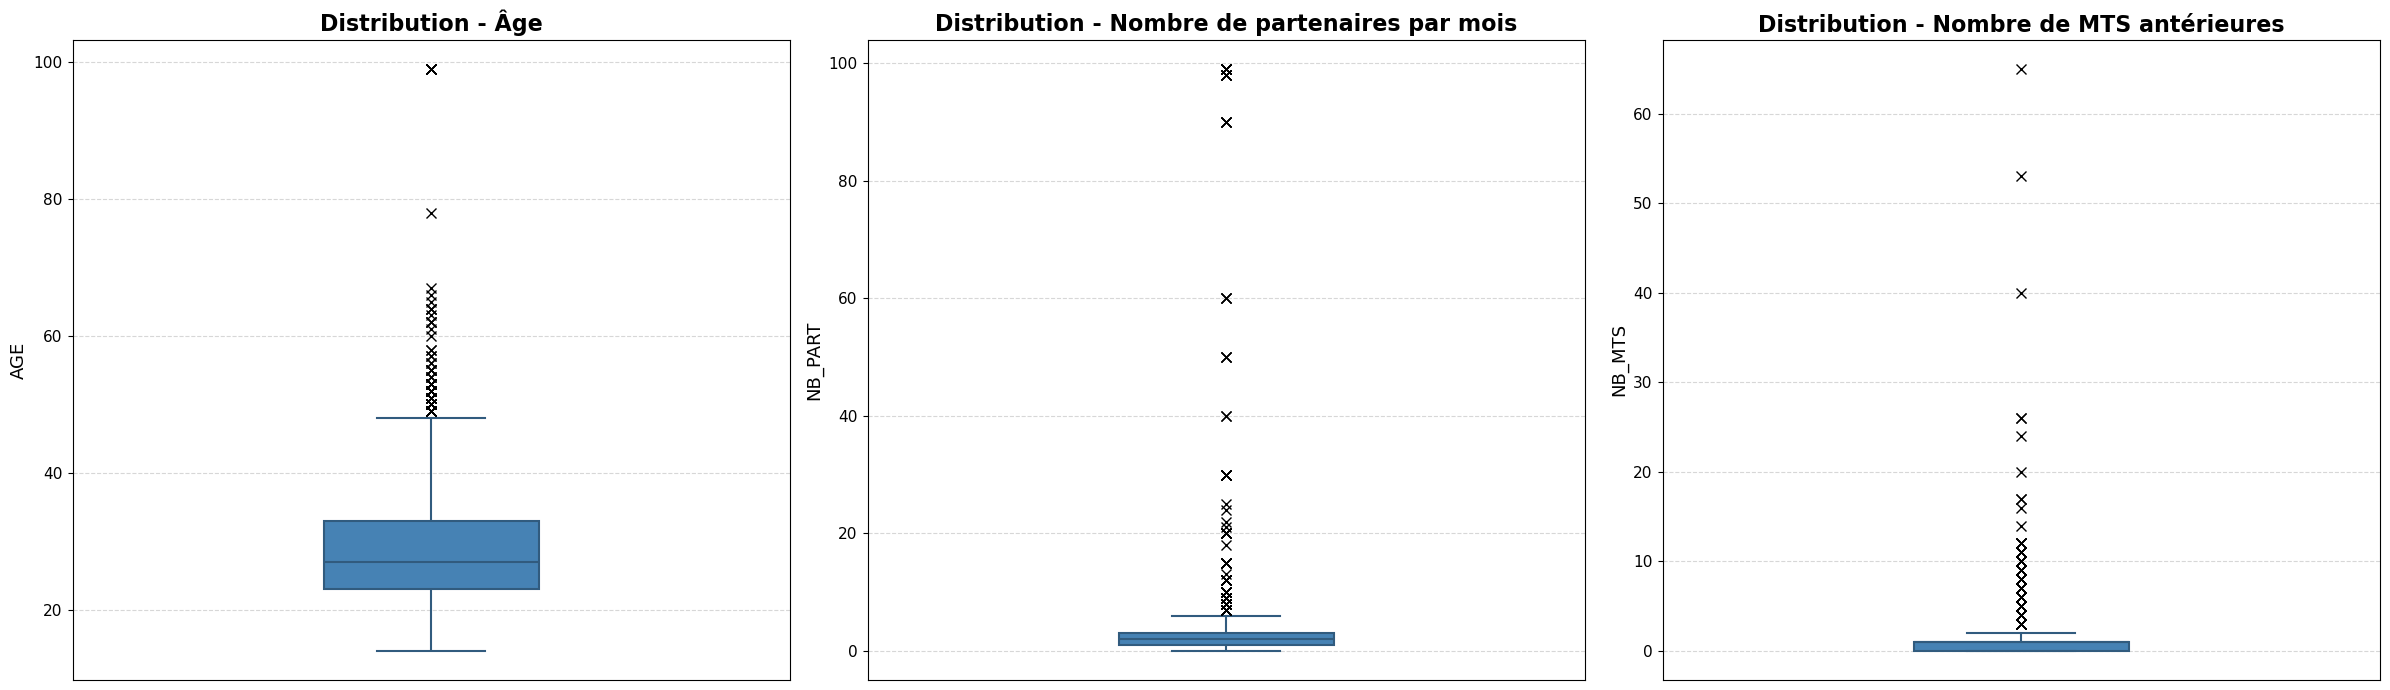

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

steelblue = (70/255, 130/255, 180/255)
steelblue_darker = tuple(c * 0.7 for c in steelblue)

# Variables continues et titres associés
vars_cont = ['AGE', 'NB_PART', 'NB_MTS']
titles = ['Âge', 'Nombre de partenaires par mois', 'Nombre de MTS antérieures']

plt.figure(figsize=(24, 7))

for i, var in enumerate(vars_cont):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(
        y=data[var],
        color=steelblue,
        width=0.3,
        boxprops=dict(facecolor=steelblue, edgecolor=steelblue_darker, linewidth=1.5),
        whiskerprops=dict(color=steelblue_darker, linewidth=1.5),
        capprops=dict(color=steelblue_darker, linewidth=1.5),
        medianprops=dict(color=steelblue_darker, linewidth=1.5),
        flierprops=dict(marker='x', markersize=7, markeredgecolor='black', linestyle='none')
    )
    plt.title(f'Distribution - {titles[i]}', fontsize=16, fontweight='bold')
    plt.ylabel(var, fontsize=13)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks([])
    plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()

In [7]:
# Transformation des valeurs aberrantes en NaN
data.loc[data['NB_MTS'] > 20, 'NB_MTS'] = np.nan
data.loc[data['NB_PART'] >= 40, 'NB_PART'] = np.nan

<br>

#### b) Traitement des valeurs manquantes 
Pour ce faire, nous avons commencée par porter une attention particulière est portée au **traitement des valeurs manquantes**. 

Dans un premier temps, nous avons considérés les bancs ainsi que les valeurs 9 pour les variables 3, 5, 6, 8, 10, 11, 12 et les valeurs 99 pour les variables 4, 9 comme des valeurs manquantes. 

Nous avons ensuite décider de supprimer toutes observations ayant plus de 2 valeurs manquantes ainsi que les observations où notre variables dépendantes, DIAGN, était une valeur manquante. 

Pour le reste des valeurs manquantes, n'ont avons décider de leur appliquer la médiane.

In [8]:
df_new = data.copy()

df_new.replace("", np.nan, inplace=True) # Remplacer les blancs en NaN

# Remplacer les valeurs 9 par NaN dans les colonnes des variables 3, 5, 6, 8, 10, 11, 12
cols_9 = ['ETAT_C', 'ORIENT_SEX', 'MTS_ANT', 'RAISON', 'HISTOIRE', 'CULTURE', 'DIAGN']  # Correspond aux variables 3, 5, 6, 8, 10, 11, 12
df_new[cols_9] = df_new[cols_9].replace(9, pd.NA)

# Remplacer les valeurs 99 par NaN dans les colonnes des variables 4, 9
cols_99 = ['AGE', 'NB_PART']  # Correspond aux variables 4, 9
df_new[cols_99] = df_new[cols_99].replace(99, pd.NA)

print(df_new.isna().sum())

ID              0
SEXE            0
ETAT_C          4
AGE             6
ORIENT_SEX    257
MTS_ANT         0
NB_MTS          6
RAISON          2
NB_PART        83
HISTOIRE      107
CULTURE        73
DIAGN          73
dtype: int64


In [9]:
df_new2 = df_new.dropna(thresh=df_new.shape[1] - 2) # Supprimer les lignes avec au moins 2 NaN
df_new2 = df_new2[df_new2['DIAGN'].notna()] # Supprimer les lignes où DIAGN est NaN
print(df_new2.isna().sum())

ID              0
SEXE            0
ETAT_C          4
AGE             6
ORIENT_SEX    246
MTS_ANT         0
NB_MTS          6
RAISON          2
NB_PART        80
HISTOIRE      102
CULTURE         0
DIAGN           0
dtype: int64


In [10]:
import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

df_new3 = df_new2.copy()

df_new3['SEXE'] = df_new3['SEXE'].fillna(df_new3['SEXE'].median())
df_new3['ETAT_C'] = df_new3['ETAT_C'].fillna(df_new3['ETAT_C'].median())
df_new3['AGE'] = df_new3['AGE'].fillna(df_new3['AGE'].median())
df_new3['ORIENT_SEX'] = df_new3['ORIENT_SEX'].fillna(df_new3['ORIENT_SEX'].median())
df_new3['MTS_ANT'] = df_new3['MTS_ANT'].fillna(df_new3['MTS_ANT'].median())
df_new3['NB_MTS'] = df_new3['NB_MTS'].fillna(df_new3['NB_MTS'].median())
df_new3['RAISON'] = df_new3['RAISON'].fillna(df_new3['RAISON'].median())
df_new3['NB_PART'] = df_new3['NB_PART'].fillna(df_new3['NB_PART'].median())
df_new3['HISTOIRE'] = df_new3['HISTOIRE'].fillna(df_new3['HISTOIRE'].median())
df_new3['CULTURE'] = df_new3['CULTURE'].fillna(df_new3['CULTURE'].median())

# summarize the shape of the data with missing rows remove
print(df_new3.shape)
print(df_new3.isna().sum())
df_new3.info()

(3071, 12)
ID            0
SEXE          0
ETAT_C        0
AGE           0
ORIENT_SEX    0
MTS_ANT       0
NB_MTS        0
RAISON        0
NB_PART       0
HISTOIRE      0
CULTURE       0
DIAGN         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 3071 entries, 0 to 3142
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          3071 non-null   int64  
 1   SEXE        3071 non-null   int64  
 2   ETAT_C      3071 non-null   object 
 3   AGE         3071 non-null   object 
 4   ORIENT_SEX  3071 non-null   object 
 5   MTS_ANT     3071 non-null   int64  
 6   NB_MTS      3071 non-null   float64
 7   RAISON      3071 non-null   object 
 8   NB_PART     3071 non-null   float64
 9   HISTOIRE    3071 non-null   object 
 10  CULTURE     3071 non-null   object 
 11  DIAGN       3071 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 311.9+ KB


In [28]:
# Conversion en int64 après suppression des NaN
for col in df_new3.select_dtypes(include='object').columns:
    df_new3[col] = df_new3[col].astype('int64')

df_new3.info()
df_new3.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3071 entries, 0 to 3142
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          3071 non-null   int64  
 1   SEXE        3071 non-null   int64  
 2   ETAT_C      3071 non-null   int64  
 3   AGE         3071 non-null   int64  
 4   ORIENT_SEX  3071 non-null   int64  
 5   MTS_ANT     3071 non-null   int64  
 6   NB_MTS      3071 non-null   float64
 7   RAISON      3071 non-null   int64  
 8   NB_PART     3071 non-null   float64
 9   HISTOIRE    3071 non-null   int64  
 10  CULTURE     3071 non-null   int64  
 11  DIAGN       3071 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 311.9 KB


,ID,SEXE,ETAT_C,AGE,ORIENT_SEX,MTS_ANT,NB_MTS,RAISON,NB_PART,HISTOIRE,CULTURE,DIAGN
0,1002,1,1,29,1,2,8.0,3,5.0,0,0,0
1,1010,1,1,18,1,1,0.0,2,1.0,1,1,1
2,1011,1,1,24,1,2,1.0,1,2.0,0,0,0
3,1012,1,1,29,1,2,3.0,1,6.0,0,1,1
4,1013,1,3,28,1,2,3.0,1,2.0,0,0,0


<br>

#### c) transformations variables 

In [29]:
df_new4 = df_new3.copy()

df_new4['AGE'] = (df_new4['AGE'] >= 30).astype(int) # l'âge considéré comme une variable dichotomique séparant les moins de 30 ans des 30 ans et plus

df_new4.drop(columns='NB_MTS', inplace=True) # Supprimer l'ancienne colonne NB_PART car plus utile

position = df_new4.columns.get_loc('NB_PART') + 1
df_new4.insert(position, 'PART', (df_new4['NB_PART'] >= 3).astype(int)) # nombre de partenaires considéré comme une variable dichotomique séparant les peu actifs des très actifs
df_new4.drop(columns='NB_PART', inplace=True) # Supprimer l'ancienne colonne NB_PART car plus utile

# Création d'une nouvelle variable binaire : 1 = Marié, 0 = Non marié
df_new4['MARIE'] = df_new4['ETAT_C'].apply(lambda x: 1 if x == 2 else 0)


df_new4 = df_new4.drop(['ID'], axis=1)
df_new4 = df_new4.drop(['ETAT_C'], axis=1)


df_new4['SEXE'] = df_new4['SEXE'].replace({1: 0, 2: 1}) # Recoder en 0,1 plutôt que 1,2
df_new4['ORIENT_SEX'] = df_new4['ORIENT_SEX'].replace({1: 0, 2: 1})
df_new4['MTS_ANT'] = df_new4['MTS_ANT'].replace({1: 0, 2: 1})

# Réorganiser les colonnes pour mettre DIAGN en dernière position
col_order = [col for col in df_new4.columns if col != 'DIAGN'] + ['DIAGN']
df_new4 = df_new4[col_order]

df_new4.info()
df_new4.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3071 entries, 0 to 3142
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   SEXE        3071 non-null   int64
 1   AGE         3071 non-null   int32
 2   ORIENT_SEX  3071 non-null   int64
 3   MTS_ANT     3071 non-null   int64
 4   RAISON      3071 non-null   int64
 5   PART        3071 non-null   int32
 6   HISTOIRE    3071 non-null   int64
 7   CULTURE     3071 non-null   int64
 8   MARIE       3071 non-null   int64
 9   DIAGN       3071 non-null   int64
dtypes: int32(2), int64(8)
memory usage: 239.9 KB


,SEXE,AGE,ORIENT_SEX,MTS_ANT,RAISON,PART,HISTOIRE,CULTURE,MARIE,DIAGN
0,0,0,0,1,3,1,0,0,0,0
1,0,0,0,0,2,0,1,1,0,1
2,0,0,0,1,1,0,0,0,0,0
3,0,0,0,1,1,1,0,1,0,1
4,0,0,0,1,1,0,0,0,0,0


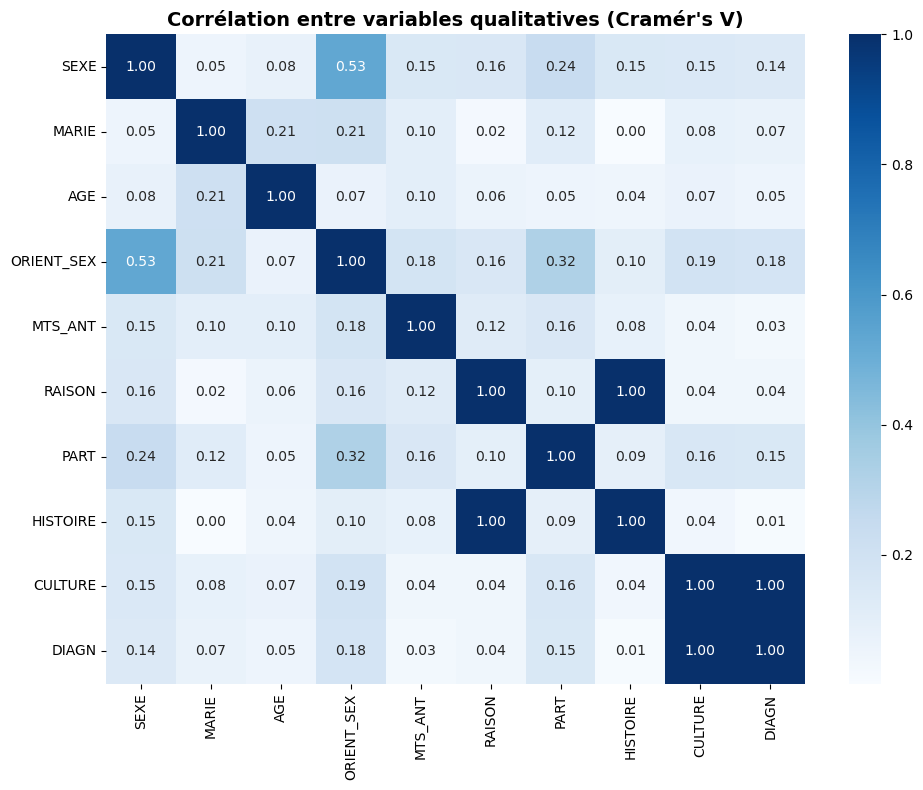

In [32]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Liste des variables qualitatives
qual_vars = ['SEXE', 'MARIE', 'AGE', 'ORIENT_SEX', 'MTS_ANT', 'RAISON', 'PART', 'HISTOIRE', 'CULTURE', 'DIAGN']

# Matrice de corrélation Cramér's V
cramer_matrix = pd.DataFrame(index=qual_vars, columns=qual_vars)

for col1 in qual_vars:
    for col2 in qual_vars:
        cramer_matrix.loc[col1, col2] = cramers_v(df_new4[col1], df_new4[col2])

cramer_matrix = cramer_matrix.astype(float)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cramer_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title("Corrélation entre variables qualitatives (Cramér's V)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Le V de Cramér est une mesure statistique utilisée pour évaluer la force de l'association entre deux variables nominales. Il est dérivé de la statistique du chi carré et fournit une valeur comprise entre 0 et 1, où 0 indique l'absence d'association et 1 indique une association parfaite.

Ici, deux couples de variables apparaissent comme fortement redondants : **CULTURE et DIAGN**, qui mesurent tous deux le résultat du dépistage de la gonorrhée (avec une corrélation parfaite), ainsi que **RAISON et HISTOIRE**, où la déclaration d’un partenaire contaminé est systématiquement associée à un motif de consultation pour contact. Afin d’éviter la multicolinéarité, une sélection des variables à inclure dans le modèle sera donc nécessaire.

<br>

In [33]:
df = df_new4.copy()
df = df.drop(['CULTURE'], axis=1)
df = df.drop(['RAISON'], axis=1)

<br>

### I.IV - Équilibre de la variable cible 

Nous avons ensuite examiné la répartition des diagnostics : **les données ne présentent pas de fort déséquilibre**, avec environ 25 % des observations correspondant à un cas de gonorrhée (soit 766 cas sur un total de 3 071).

In [15]:
df.DIAGN.value_counts()

DIAGN
0    2305
1     766
Name: count, dtype: int64

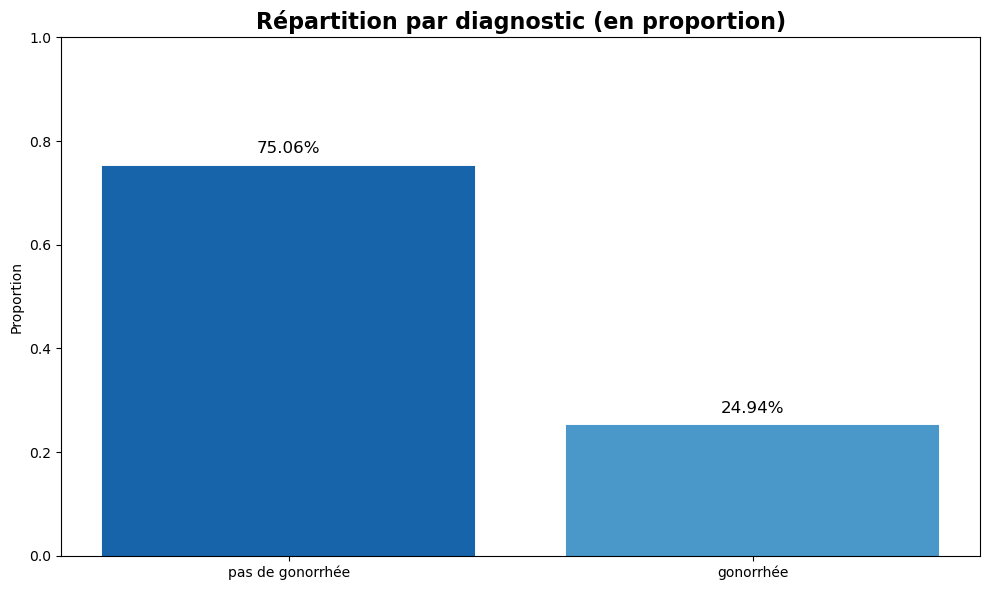

In [17]:
import matplotlib.pyplot as plt
from matplotlib import colormaps

proportions = df['DIAGN'].value_counts(normalize=True).sort_index()
labels = ['pas de gonorrhée', 'gonorrhée']

cmap = colormaps['Blues']
colors = [cmap(0.8), cmap(0.6)]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, proportions, color=colors, edgecolor=colors, linewidth=1.5)

plt.title("Répartition par diagnostic (en proportion)", fontsize=16, fontweight='bold')
plt.ylabel("Proportion")
plt.ylim(0, 1)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2%}", 
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

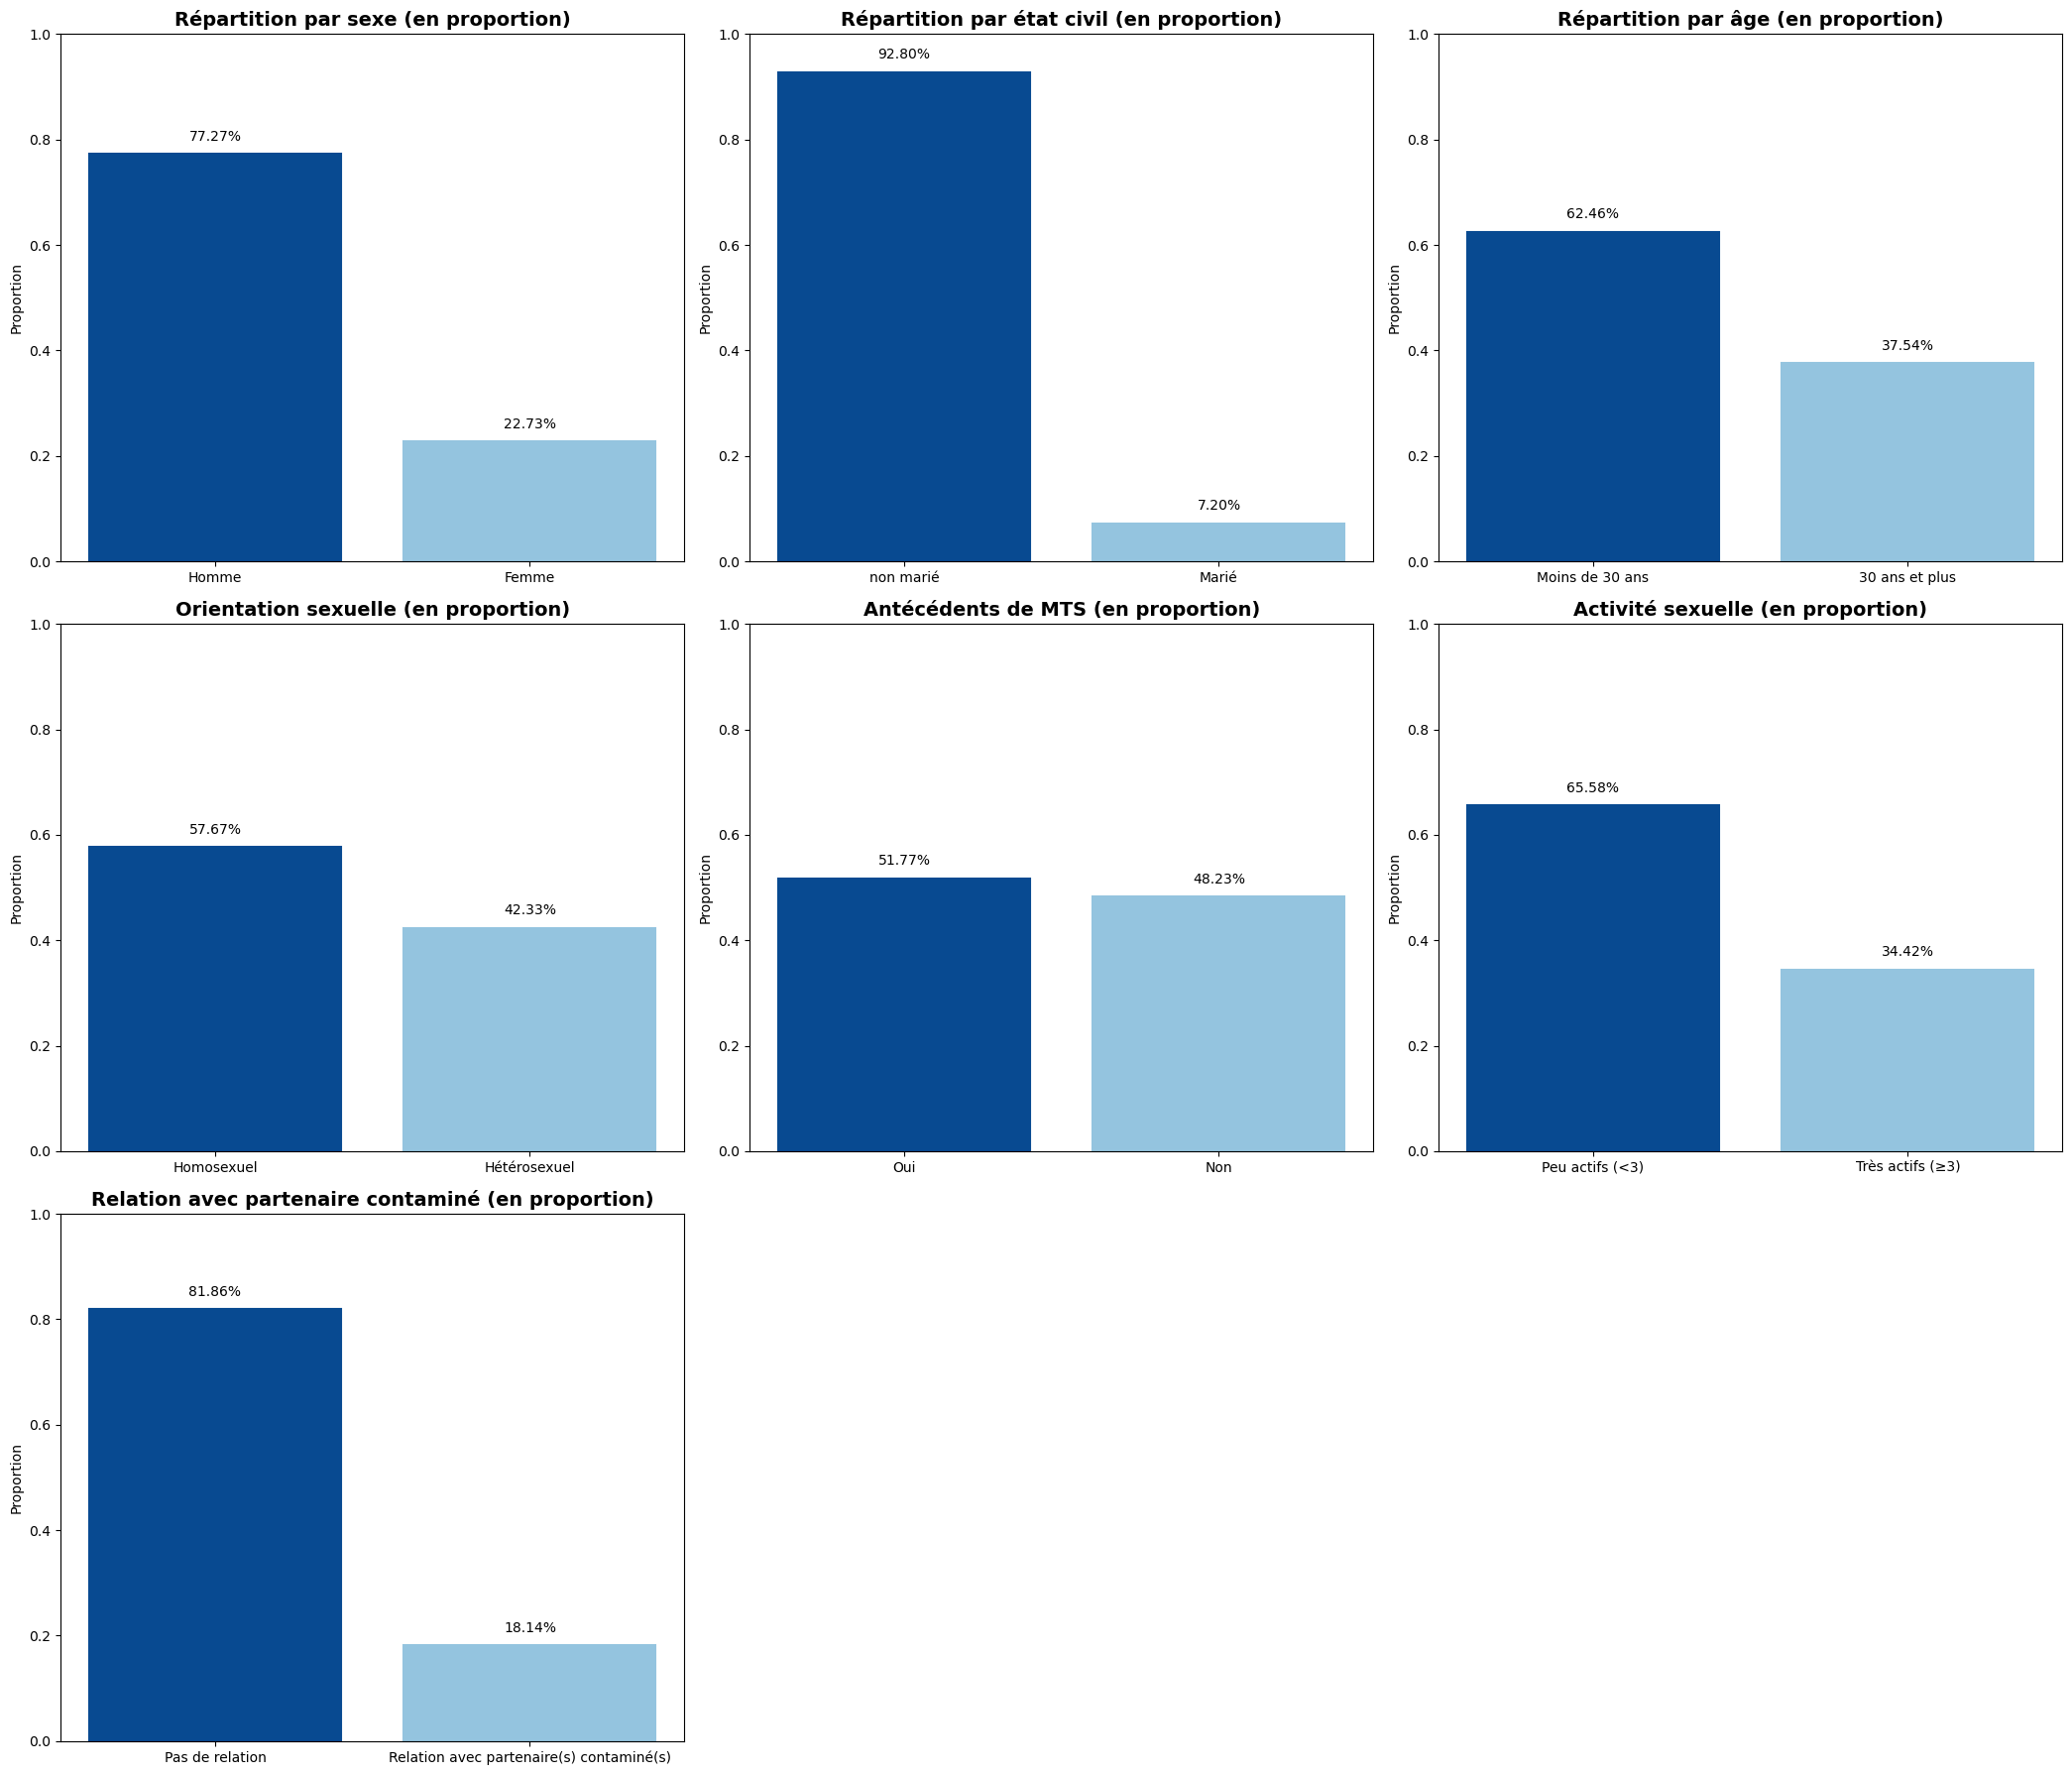

In [36]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import pandas as pd

plots = []

# Sexe
sexe_labels = {0: 'Homme', 1: 'Femme'}
sexe_prop = df['SEXE'].value_counts(normalize=True).sort_values(ascending=False)
plots.append(([sexe_labels[i] for i in sexe_prop.index], sexe_prop.values, "Répartition par sexe"))

# État civil
etat_labels = {0: "non marié", 1: "Marié"}
etat_prop = df['MARIE'].value_counts(normalize=True).sort_values(ascending=False)
plots.append(([etat_labels.get(i, f"Valeur {i}") for i in etat_prop.index], etat_prop.values, "Répartition par état civil"))

# Âge
age_labels = {0: 'Moins de 30 ans', 1: '30 ans et plus'}
age_prop = df['AGE'].value_counts(normalize=True).sort_values(ascending=False)
plots.append(([age_labels[i] for i in age_prop.index], age_prop.values, "Répartition par âge"))

# Orientation sexuelle
orient_labels = {0: 'Homosexuel', 1: 'Hétérosexuel'}
orient_prop = df['ORIENT_SEX'].value_counts(normalize=True).sort_values(ascending=False)
plots.append(([orient_labels.get(i, f"Valeur {i}") for i in orient_prop.index], orient_prop.values, "Orientation sexuelle"))

# Antécédents MTS
mts_labels = {0: "Non", 1: "Oui"}
mts_prop = df['MTS_ANT'].value_counts(normalize=True).sort_values(ascending=False)
plots.append(([mts_labels[i] for i in mts_prop.index], mts_prop.values, "Antécédents de MTS"))

# Activité sexuelle
part_labels = {0: 'Peu actifs (<3)', 1: 'Très actifs (≥3)'}
part_prop = df['PART'].value_counts(normalize=True).sort_values(ascending=False)
plots.append(([part_labels[i] for i in part_prop.index], part_prop.values, "Activité sexuelle"))

# Histoire de partenaire contaminé
histoire_labels = {0: "Pas de relation", 1: "Relation avec partenaire(s) contaminé(s)"}
histoire_prop = df['HISTOIRE'].value_counts(normalize=True).sort_values(ascending=False)
plots.append(([histoire_labels[i] for i in histoire_prop.index], histoire_prop.values, "Relation avec partenaire contaminé"))

# Création des sous-graphiques
n_plots = len(plots)
cols = 3
rows = (n_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(21, 6 * rows))
axes = axes.flatten()

for i, (labels, values, title) in enumerate(plots):
    n = len(labels)
    cmap = colormaps['Blues']
    colors = [cmap(0.4 + 0.5 * (n - j - 1) / max(n - 1, 1)) for j in range(n)]

    axes[i].bar(labels, values, color=colors, edgecolor=colors, linewidth=1.5)
    axes[i].set_title(title + " (en proportion)", fontsize=14, fontweight='bold')
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel("Proportion")

    if len(labels) > 5:
        axes[i].tick_params(axis='x', rotation=30)

    for j, value in enumerate(values):
        axes[i].text(j, value + 0.02, f"{value:.2%}", ha='center', va='bottom', fontsize=10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("repartition_variables.png", dpi=300)
plt.show()

<br>
<br>

____

## **II - Analyse descriptive des données**

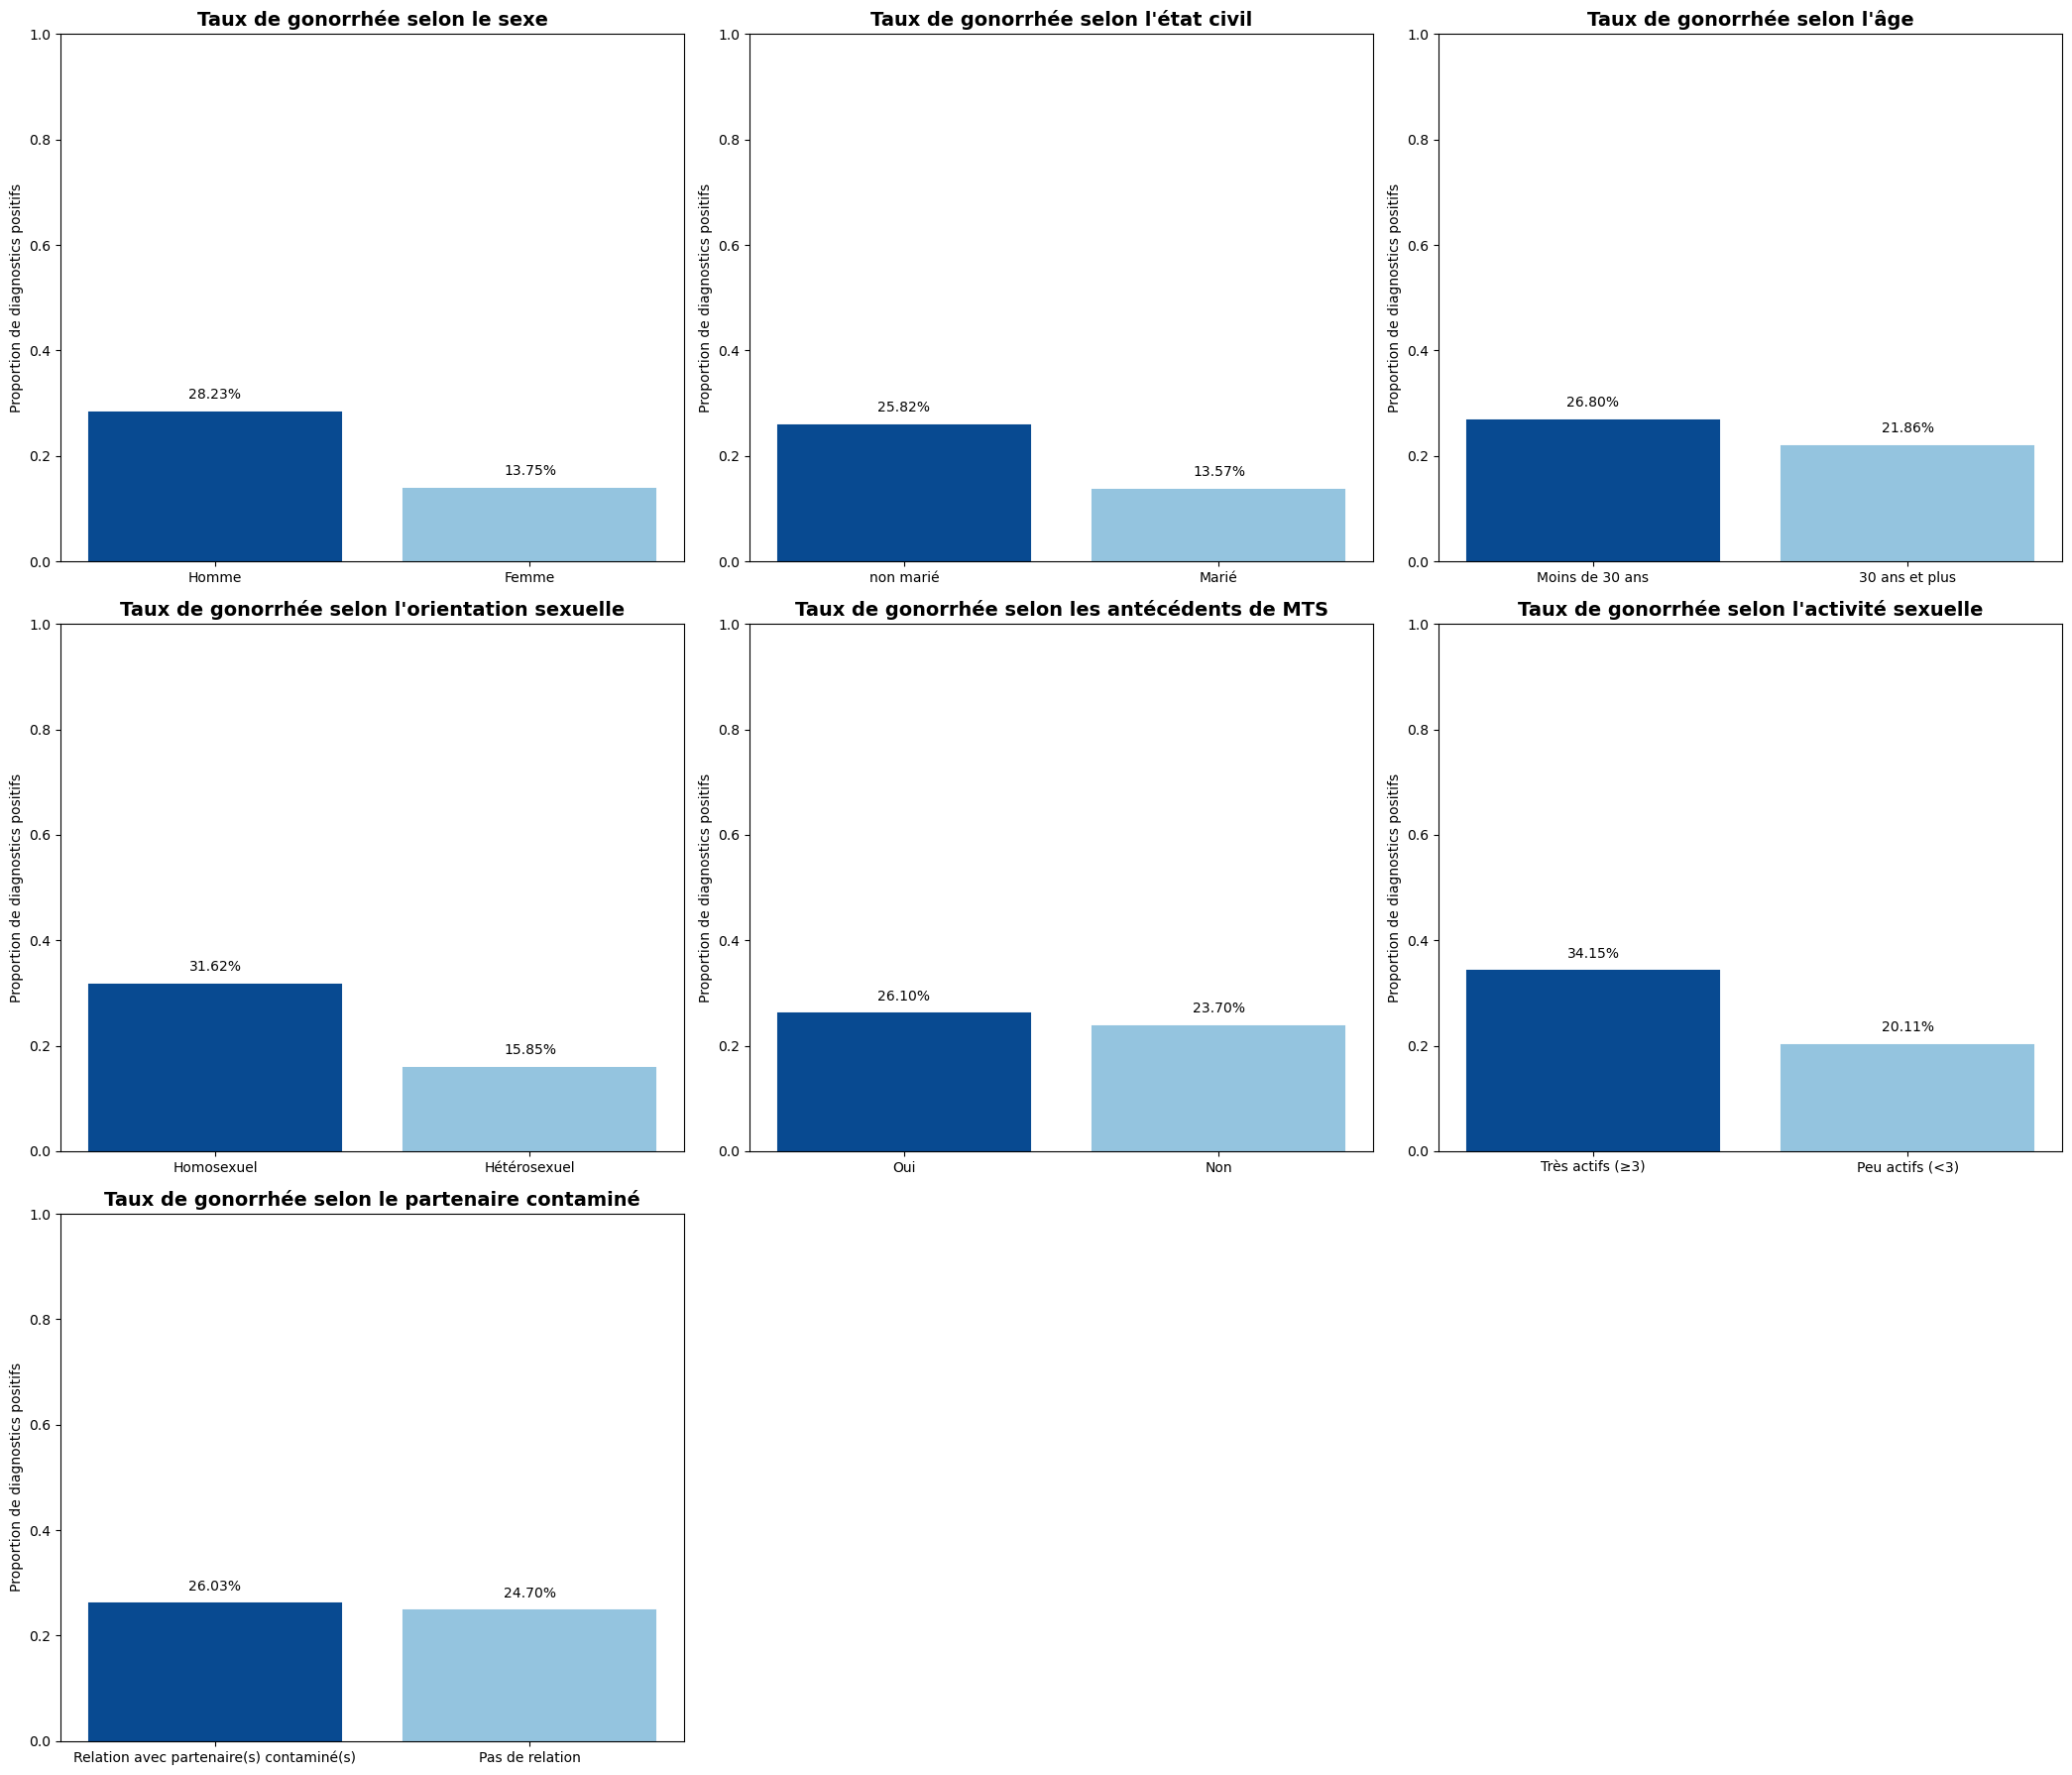

In [34]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import pandas as pd

plots = []

# Sexe
sexe_labels = {0: 'Homme', 1: 'Femme'}
sexe_rate = df.groupby('SEXE')['DIAGN'].mean().sort_values(ascending=False)
plots.append(([sexe_labels[i] for i in sexe_rate.index], sexe_rate.values, "Taux de gonorrhée selon le sexe"))

# État civil
etat_labels = {0: "non marié", 1: "Marié"}
etat_rate = df.groupby('MARIE')['DIAGN'].mean().sort_values(ascending=False)
plots.append(([etat_labels.get(i, f"Valeur {i}") for i in etat_rate.index], etat_rate.values, "Taux de gonorrhée selon l'état civil"))

# Âge
age_labels = {0: 'Moins de 30 ans', 1: '30 ans et plus'}
age_rate = df.groupby('AGE')['DIAGN'].mean().sort_values(ascending=False)
plots.append(([age_labels[i] for i in age_rate.index], age_rate.values, "Taux de gonorrhée selon l'âge"))

# Orientation sexuelle
orient_labels = {0: 'Homosexuel', 1: 'Hétérosexuel'}
orient_rate = df.groupby('ORIENT_SEX')['DIAGN'].mean().sort_values(ascending=False)
plots.append(([orient_labels.get(i, f"Valeur {i}") for i in orient_rate.index], orient_rate.values, "Taux de gonorrhée selon l'orientation sexuelle"))

# Antécédents MTS
mts_labels = {0: "Non", 1: "Oui"}
mts_rate = df.groupby('MTS_ANT')['DIAGN'].mean().sort_values(ascending=False)
plots.append(([mts_labels[i] for i in mts_rate.index], mts_rate.values, "Taux de gonorrhée selon les antécédents de MTS"))

# Activité sexuelle
part_labels = {0: 'Peu actifs (<3)', 1: 'Très actifs (≥3)'}
part_rate = df.groupby('PART')['DIAGN'].mean().sort_values(ascending=False)
plots.append(([part_labels[i] for i in part_rate.index], part_rate.values, "Taux de gonorrhée selon l'activité sexuelle"))

# Historique partenaire contaminé
histoire_labels = {0: "Pas de relation", 1: "Relation avec partenaire(s) contaminé(s)"}
histoire_rate = df.groupby('HISTOIRE')['DIAGN'].mean().sort_values(ascending=False)
plots.append(([histoire_labels[i] for i in histoire_rate.index], histoire_rate.values, "Taux de gonorrhée selon le partenaire contaminé"))

# Création des sous-graphiques
n_plots = len(plots)
cols = 3
rows = (n_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(21, 6 * rows))
axes = axes.flatten()

for i, (labels, values, title) in enumerate(plots):
    n = len(labels)
    cmap = colormaps['Blues']
    colors = [cmap(0.4 + 0.5 * (n - j - 1) / max(n - 1, 1)) for j in range(n)]

    axes[i].bar(labels, values, color=colors, edgecolor=colors, linewidth=1.5)
    axes[i].set_title(title, fontsize=14, fontweight='bold')
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel("Proportion de diagnostics positifs")

    if len(labels) > 5:
        axes[i].tick_params(axis='x', rotation=30)

    for j, value in enumerate(values):
        axes[i].text(j, value + 0.02, f"{value:.2%}", ha='center', va='bottom', fontsize=10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("taux_gonorrhee_par_modalite_tries.png", dpi=300)
plt.show()

In [38]:
# Dictionnaires de labels
sexe_labels = {0: 'Homme', 1: 'Femme'}
orient_labels = {0: 'Homosexuel', 1: 'Hétérosexuel'}
part_labels = {0: 'Peu actifs', 1: 'Très actifs'}
age_labels = {0: 'Moins de 30 ans', 1: '30 ans et plus'}
raison_labels = {1: "Symptôme", 2: "Contact", 3: "Dépistage", 4: "Contrôle", 5: "Autre"}
histoire_labels = {0: "Pas de relation", 1: "Partenaire contaminé"}

def barplot_proportion_cote_a_cote(group_var, hue_var, labels_group, labels_hue, title, xlabel):
    grouped = df[df['DIAGN'] == 1].groupby([group_var, hue_var]).size()
    totals = df.groupby([group_var, hue_var]).size()
    proportions = (grouped / totals).unstack().fillna(0)

    proportions.index = [labels_group.get(i, str(i)) for i in proportions.index]
    proportions.columns = [labels_hue.get(i, str(i)) for i in proportions.columns]

    x = np.arange(len(proportions.index))
    width = 0.35
    cmap = colormaps['Blues']
    colors = [cmap(0.6), cmap(0.8)]

    fig, ax = plt.subplots(figsize=(10, 6))

    bars1 = ax.bar(x - width/2, proportions.iloc[:, 0], width, label=proportions.columns[0], color=colors[0], edgecolor='white')
    bars2 = ax.bar(x + width/2, proportions.iloc[:, 1], width, label=proportions.columns[1], color=colors[1], edgecolor='white')

    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_ylabel("Proportion de gonorrhée")
    ax.set_xlabel(xlabel)
    ax.set_xticks(x)
    ax.set_xticklabels(proportions.index)
    ax.set_ylim(0, 1)
    ax.legend(title=hue_var)

    # Pourcentages au-dessus des barres
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.0%}",
                    ha='center', va='bottom', fontsize=11)

    plt.tight_layout()
    plt.show()

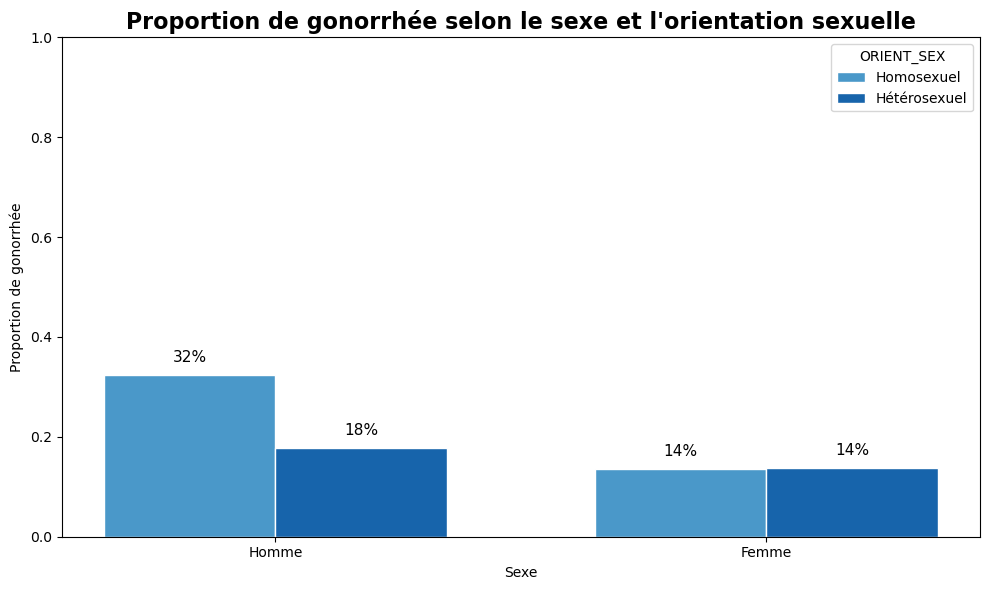

In [39]:
# Sexe × Orientation sexuelle
barplot_proportion_cote_a_cote('SEXE', 'ORIENT_SEX', sexe_labels, orient_labels, "Proportion de gonorrhée selon le sexe et l'orientation sexuelle", "Sexe")
plt.show()
# Note : chaque barre représente le % de personnes atteintes de gonorrhée dans un groupe sexe × orientation sexuelle

> Le graphique montre que 32 % des hommes homosexuels sont atteints de gonorrhée, contre 18 % des hommes hétérosexuels. Chez les femmes, les proportions sont similaires entre homosexuelles et hétérosexuelles (14 %). L’écart observé chez les hommes met en évidence une différence de fréquence des cas selon l’orientation sexuelle, qui n’apparaît pas chez les femmes.

<br>

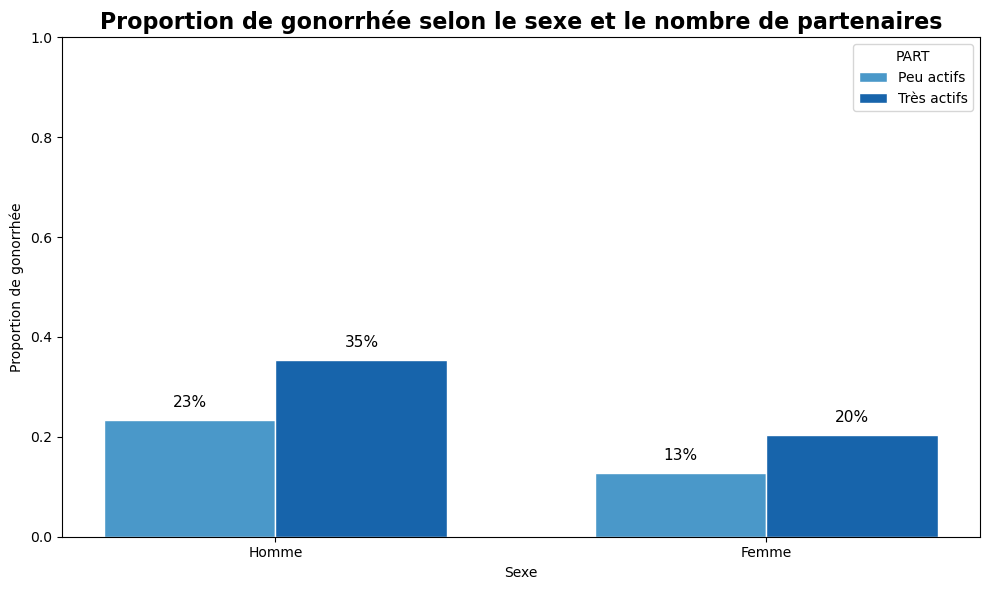

In [40]:
barplot_proportion_cote_a_cote('SEXE', 'PART', sexe_labels, part_labels, "Proportion de gonorrhée selon le sexe et le nombre de partenaires", "Sexe")
plt.show()
# Note : chaque barre représente le % de personnes ayant eu une gonorrhée selon leur sexe et niveau d’activité sexuelle

> Le graphique indique que la proportion de gonorrhée est plus élevée chez les individus très actifs sexuellement, quel que soit le sexe. Chez les hommes, 36 % des très actifs sont atteints, contre 23 % des peu actifs. Chez les femmes, les proportions sont respectivement de 22 % et 12 %. Cette différence entre les niveaux d’activité sexuelle est observée dans les deux groupes, avec des niveaux globalement plus élevés chez les hommes.

<br>

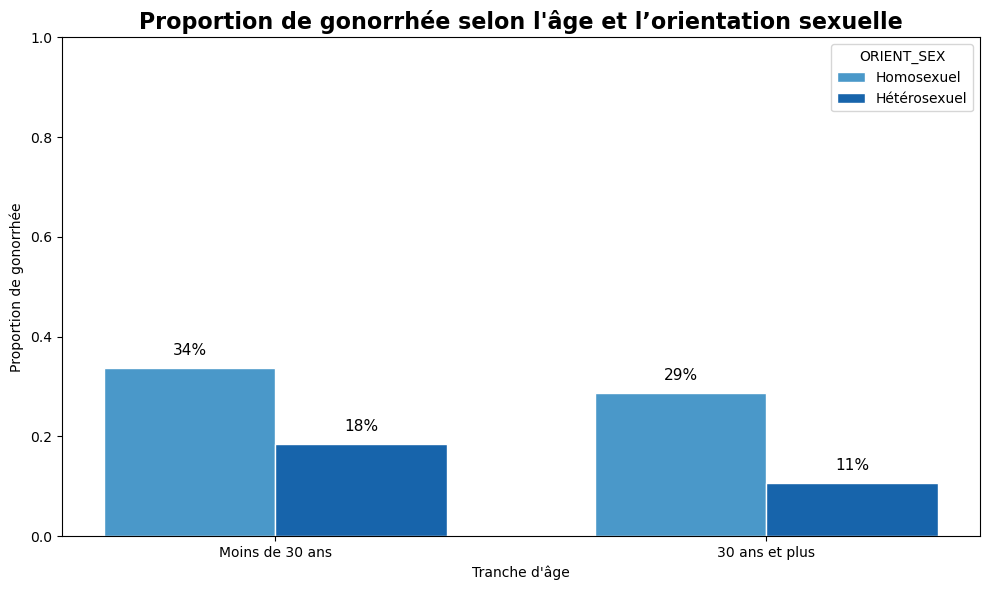

In [41]:
barplot_proportion_cote_a_cote('AGE', 'ORIENT_SEX', age_labels, orient_labels, "Proportion de gonorrhée selon l'âge et l’orientation sexuelle", "Tranche d'âge")
plt.show()
# Note : chaque barre représente le % de cas de gonorrhée dans un groupe défini par l’âge et l’orientation sexuelle

> Le graphique indique que, dans les deux tranches d’âge, les personnes homosexuelles présentent une proportion plus élevée de gonorrhée que les personnes hétérosexuelles. Chez les moins de 30 ans, les taux sont de 34 % pour les homosexuels et 18 % pour les hétérosexuels. Chez les 30 ans et plus, les proportions sont respectivement de 29 % et 11 %. L’écart entre orientations reste présent quel que soit l’âge, avec des niveaux plus élevés observés chez les plus jeunes.

<br>

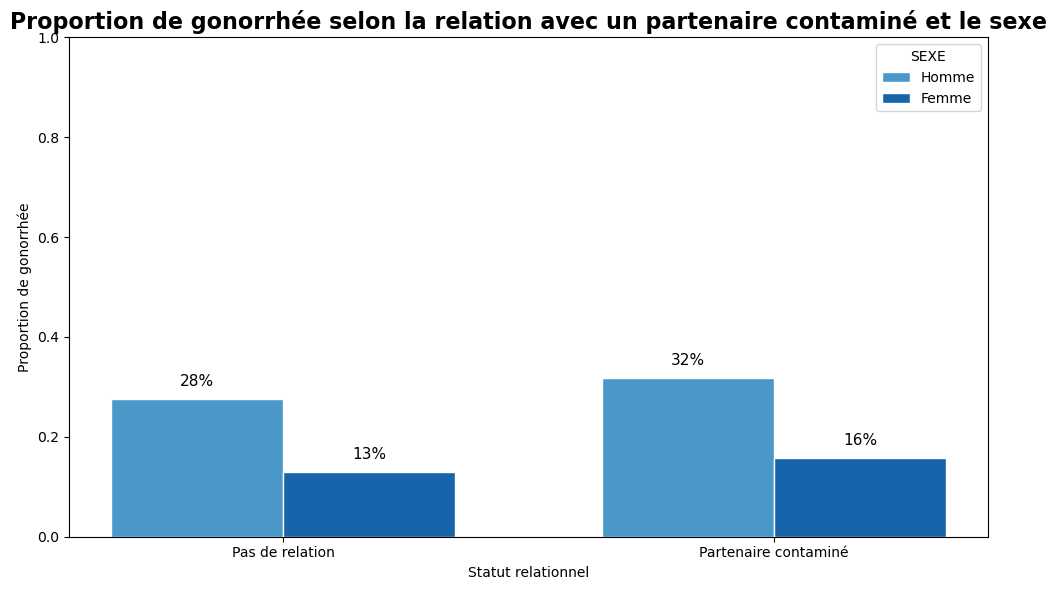

In [42]:
barplot_proportion_cote_a_cote('HISTOIRE', 'SEXE', histoire_labels, sexe_labels,"Proportion de gonorrhée selon la relation avec un partenaire contaminé et le sexe", "Statut relationnel")
plt.show()
# Note : chaque barre correspond au % de personnes infectées selon le sexe et le statut du partenaire déclaré

> Les proportions de gonorrhée sont plus élevées chez les hommes que chez les femmes, que la personne ait déclaré une relation avec un partenaire contaminé ou non. Chez les hommes, elles s’élèvent à 28 % sans relation déclarée et 32 % en cas de partenaire contaminé. Chez les femmes, ces proportions sont de 13 % et 16 %. Les différences selon le statut relationnel sont faibles, surtout chez les hommes.

<br>

<br>

**Dans l’ensemble, ces résultats permettent d’identifier des profils différenciés en termes de fréquence d’infection, sans pour autant isoler une variable unique prédictive. Cela justifie la mise en place d’une analyse pour évaluer l’effet propre de chaque facteur en contrôlant les autres.**

<br>

<br>

----

## **III - Analyse prédictive**
### III.I – Choix des variables 
#### a) Test du Chi²

In [43]:
import pandas as pd
from scipy.stats import chi2_contingency

# Liste des variables explicatives qualitatives
qual_vars = ['SEXE', 'MARIE', 'AGE', 'ORIENT_SEX', 'MTS_ANT', 'PART', 'HISTOIRE']

chi2_results = []

for var in qual_vars:
    contingency = pd.crosstab(df['DIAGN'], df[var])
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi2_results.append({
        'Variable': var,
        'Chi2': round(chi2, 3),
        'p-value': round(p, 4),
        'ddl': dof
    })

# Affichage des résultats
chi2_df = pd.DataFrame(chi2_results)
chi2_df.sort_values('p-value', inplace=True)
chi2_df.reset_index(drop=True, inplace=True)
chi2_df

,Variable,Chi2,p-value,ddl
0,SEXE,59.640,0.0000,1
1,ORIENT_SEX,98.802,0.0000,1
2,PART,72.281,0.0000,1
3,MARIE,15.791,0.0001,1
4,AGE,9.135,0.0025,1
5,MTS_ANT,2.234,0.1350,1
6,HISTOIRE,0.363,0.5468,1


<br>

#### b) Best model

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import numpy as np

In [552]:
X = df.drop(['DIAGN'], axis=1)
y = df['DIAGN']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
import warnings
warnings.filterwarnings('ignore')

In [406]:
import statsmodels.api as sm

def processSubset(feature_set):
    try:
        X_subset = sm.add_constant(X[list(feature_set)], has_constant='add')  
        # Entraîner un modèle de régression logistique
        model = sm.Logit(y, X_subset)
        regr = model.fit(disp=0)
        LL = regr.llf  # Log-Likelihood
        
        return {"model": regr, "Log-Likelihood": LL}
    except (np.linalg.LinAlgError, ValueError):
        # En cas d'erreur de matrice singulière ou d'autre erreur
        return {"model": None, "Log-Likelihood": -np.inf}

def getBest(k):
    tic = time.time()
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        result = processSubset(combo)
        if result["model"] is not None:
            results.append(result)
    
    if len(results) > 0:
        models = pd.DataFrame(results)
        
        if 'Log-Likelihood' in models.columns:
            best_model = models.loc[models['Log-Likelihood'].idxmax()]
        else:
            raise ValueError("La colonne 'Log-Likelihood' n'a pas été générée correctement.")
    else:
        raise ValueError("Aucun modèle valide n'a été généré.")  
    toc = time.time()
    print(f"Processed {len(results)} models on {k} predictors in {(toc-tic):.2f} seconds.")
    return best_model


models_best = pd.DataFrame(columns=["Log-Likelihood", "model"])

tic = time.time()
for i in range(1, min(10, len(X_train.columns) + 1)):
    best_model = getBest(i)
    models_best.loc[i] = [best_model["Log-Likelihood"], best_model["model"]]

toc = time.time()
print("Total elapsed time:", (toc - tic), "seconds.")

print(models_best)

Processed 8 models on 1 predictors in 0.03 seconds.
Processed 28 models on 2 predictors in 0.16 seconds.
Processed 56 models on 3 predictors in 0.23 seconds.
Processed 70 models on 4 predictors in 0.40 seconds.
Processed 56 models on 5 predictors in 0.95 seconds.
Processed 28 models on 6 predictors in 0.19 seconds.
Processed 8 models on 7 predictors in 0.17 seconds.
Processed 1 models on 8 predictors in 0.03 seconds.
Total elapsed time: 2.177696704864502 seconds.
   Log-Likelihood                                              model
1    -1673.304659  <statsmodels.discrete.discrete_model.BinaryRes...
2    -1655.519195  <statsmodels.discrete.discrete_model.BinaryRes...
3    -1647.225163  <statsmodels.discrete.discrete_model.BinaryRes...
4    -1642.467383  <statsmodels.discrete.discrete_model.BinaryRes...
5    -1639.595859  <statsmodels.discrete.discrete_model.BinaryRes...
6    -1639.388065  <statsmodels.discrete.discrete_model.BinaryRes...
7    -1639.323587  <statsmodels.discrete.discrete

In [408]:
print(models_best.loc[5, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                  DIAGN   No. Observations:                 3071
Model:                          Logit   Df Residuals:                     3065
Method:                           MLE   Df Model:                            5
Date:                Mon, 07 Apr 2025   Pseudo R-squ.:                 0.04951
Time:                        23:46:27   Log-Likelihood:                -1639.6
converged:                       True   LL-Null:                       -1725.0
Covariance Type:            nonrobust   LLR p-value:                 4.876e-35
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1166      0.183      0.637      0.524      -0.242       0.475
SEXE          -0.4541      0.140     -3.249      0.001      -0.728      -0.180
AGE           -0.3748      0.091     -4.128      0.0

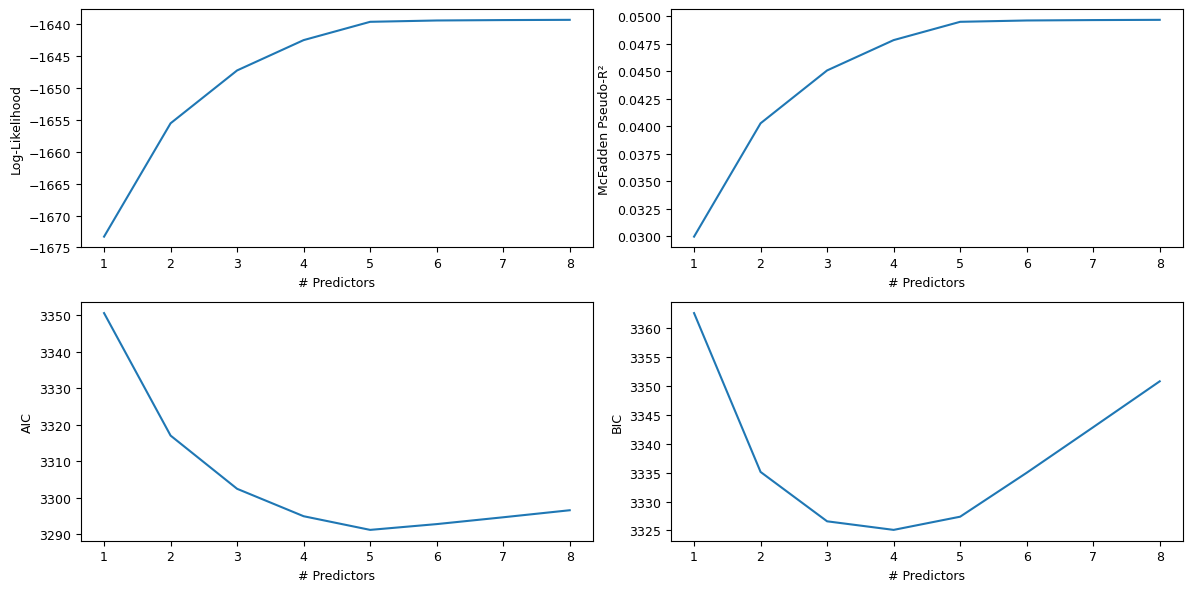

In [414]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 9, 'lines.markersize': 6})

# Log-Likelihood (On veut maximiser)
plt.subplot(2, 2, 1)
log_likelihoods = models_best.apply(lambda row: row["model"].llf if row["model"] is not None else np.nan, axis=1)
plt.plot(log_likelihoods)
plt.xlabel('# Predictors')
plt.ylabel('Log-Likelihood')

# McFadden's Pseudo-R² (On veut maximiser)
plt.subplot(2, 2, 2)
pseudo_r2 = models_best.apply(lambda row: 1 - (row["model"].llf / row["model"].llnull) if row["model"] is not None else np.nan, axis=1)
plt.plot(pseudo_r2)
plt.xlabel('# Predictors')
plt.ylabel('McFadden Pseudo-R²')

# AIC (On veut minimiser)
plt.subplot(2, 2, 3)
aic = models_best.apply(lambda row: row["model"].aic if row["model"] is not None else np.nan, axis=1)
plt.plot(aic)
plt.xlabel('# Predictors')
plt.ylabel('AIC')

# BIC (On veut minimiser)
plt.subplot(2, 2, 4)
bic = models_best.apply(lambda row: row["model"].bic if row["model"] is not None else np.nan, axis=1)
plt.plot(bic)
plt.xlabel('# Predictors')
plt.ylabel('BIC')

plt.tight_layout()
plt.show()

<br>

### III.II – Prédiction 
#### a) Régression logistique 

In [568]:
selected_columns = ['AGE', 'SEXE', 'ORIENT_SEX','PART']
X = df[selected_columns]
y = df['DIAGN']

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [570]:
X_train_const = sm.add_constant(X_train)
model = sm.Logit(y_train, X_train_const).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.537345
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  DIAGN   No. Observations:                 2149
Model:                          Logit   Df Residuals:                     2144
Method:                           MLE   Df Model:                            4
Date:                Tue, 08 Apr 2025   Pseudo R-squ.:                 0.04072
Time:                        00:00:55   Log-Likelihood:                -1154.8
converged:                       True   LL-Null:                       -1203.8
Covariance Type:            nonrobust   LLR p-value:                 2.590e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0220      0.214      0.103      0.918      -0.397       0.441
AGE           -0.3417      0.

In [572]:
# Ajouter une constante à l'ensemble de test
X_test_const = sm.add_constant(X_test)

# Calcul de la prédiction sur l'échantillon test (probabilités)
y_pred_proba = model.predict(X_test_const)

# Afficher les 5 premières probabilités prédites
print(y_pred_proba.head(10))


3002    0.290647
1758    0.212014
2530    0.290647
194     0.399181
240     0.141066
2790    0.225493
2722    0.141066
3004    0.320697
1876    0.320697
1912    0.189310
dtype: float64


Nous convertissons les probabilités en classes {0,1} en comparant avec le seuil.

In [575]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
import numpy as np
import pandas as pd

# Liste des seuils à tester
thresholds = np.arange(0.0, 1.01, 0.01)

# Pour stocker les résultats
results = []

# Boucle sur chaque seuil
for threshold in thresholds:
    # Prédire avec le seuil actuel
    y_pred_test = np.where(y_pred_proba > threshold, 1, 0)
    
    # Calcul de la matrice de confusion
    mc = confusion_matrix(y_test, y_pred_test)
    
    # Extraire les valeurs de la matrice de confusion
    tn, fp, fn, tp = mc.ravel()
    
    # Calculer le taux de faux négatifs
    fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    accuracy_rate = (tp + tn) / (tn + fp + fn + tp)
    
    # Calculer Precision, Recall, F1 Score
    precision = precision_score(y_test, y_pred_test, zero_division=0)
    recall = recall_score(y_test, y_pred_test, zero_division=0)
    f1 = f1_score(y_test, y_pred_test, zero_division=0)
    
    # Stocker les résultats
    results.append({
        'Threshold': threshold,
        'False Negatives': fn,
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'FN Rate': fn_rate,
        'Accuracy': accuracy_rate,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Convertir les résultats en DataFrame pour analyse
results_df = pd.DataFrame(results)

# Trier les résultats par F1 Score
best_threshold_f1 = results_df.loc[results_df['F1 Score'].idxmax(), 'Threshold']
best_threshold_precision = results_df.loc[results_df['Precision'].idxmax(), 'Threshold']
best_threshold_recall = results_df.loc[results_df['Recall'].idxmax(), 'Threshold']

# Afficher les résultats triés par F1 Score
print("\nRésultats triés par F1 Score :")
print(results_df.sort_values(by='F1 Score', ascending=False))

# Afficher les meilleurs seuils trouvés
print(f"\nMeilleur seuil pour maximiser le F1 Score : {best_threshold_f1}")
print(f"Meilleur seuil pour maximiser la Précision : {best_threshold_precision}")
print(f"Meilleur seuil pour maximiser le Recall : {best_threshold_recall}")


Résultats triés par F1 Score :
     Threshold  False Negatives  True Positives  True Negatives  \
22        0.22               46             187             300   
21        0.21               40             193             280   
20        0.20               40             193             280   
19        0.19               40             193             280   
27        0.27               76             157             398   
..         ...              ...             ...             ...   
64        0.64              233               0             689   
65        0.65              233               0             689   
66        0.66              233               0             689   
67        0.67              233               0             689   
100       1.00              233               0             689   

     False Positives   FN Rate  Accuracy  Precision    Recall  F1 Score  
22               389  0.197425  0.528200   0.324653  0.802575  0.462299  
21             

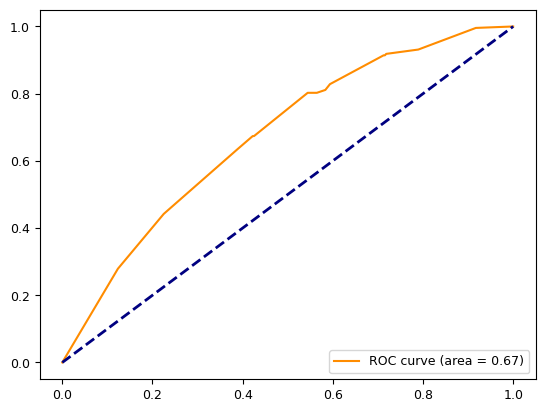

In [594]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test,y_pred_proba)
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(fpr,tpr,color="darkorange",label="ROC curve (area = %0.2f)" % auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [616]:
# L'aire sous la courbe ROC
print("AUC : %.4f" % (auc))

AUC : 0.6741


<br>

#### b) Modèle KNN 

In [702]:
selected_columns = ['AGE', 'SEXE', 'ORIENT_SEX','PART','HISTOIRE']
X = df[selected_columns]
y = df['DIAGN'] 

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
# Calcul des erreurs d'entraînement et de test pour différentes valeurs de K
training_accuracy = []
test_accuracy = []

for i in range(1, 50):  
    knn = KNeighborsClassifier(n_neighbors=i) # Définir le classifieur KNN avec k=i
    knn.fit(X_train,y_train)
    #error.append(np.sqrt(mean_squared_error(y_test,pred_i)))
    test_accuracy.append(knn.fit(X_train,y_train).score(X_test,y_test)) # Calculer l'accuracy de test
    training_accuracy.append(knn.fit(X_train,y_train).score(X_train,y_train)) # Calculer l'accuracy d'entraînement

Text(0, 0.5, 'Accuracy')

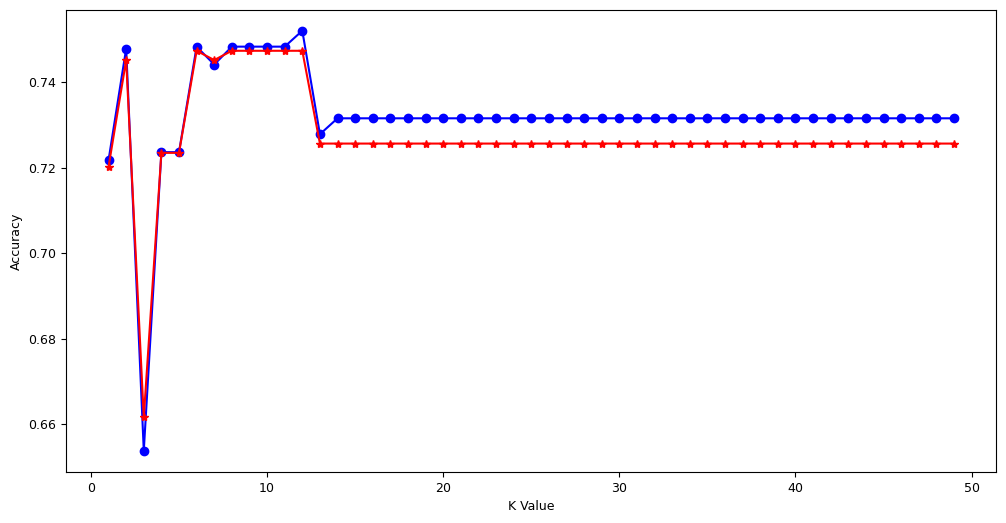

In [646]:
# Tracer l'erreur d'entraînement et d'erreur de test
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 50),training_accuracy, 'b-o', ms=6) # accuracy d'entraînement
plt.plot(range(1, 50),test_accuracy, 'r-*', ms=6) # accuracy de test
plt.xlabel('K Value')  
plt.ylabel('Accuracy')

In [648]:
# Calcul des erreurs de classification pour différentes valeurs de K (de 1 à 100)*
error1 = []
error2 = []

for i in range(1, 55):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    prad_i = knn.predict(X_train)
    #error.append(np.sqrt(mean_squared_error(y_test,pred_i)))
    error1.append(np.mean(pred_i != y_test))  
    error2.append(np.mean(prad_i != y_train))

Text(0, 0.5, ' Mean Error')

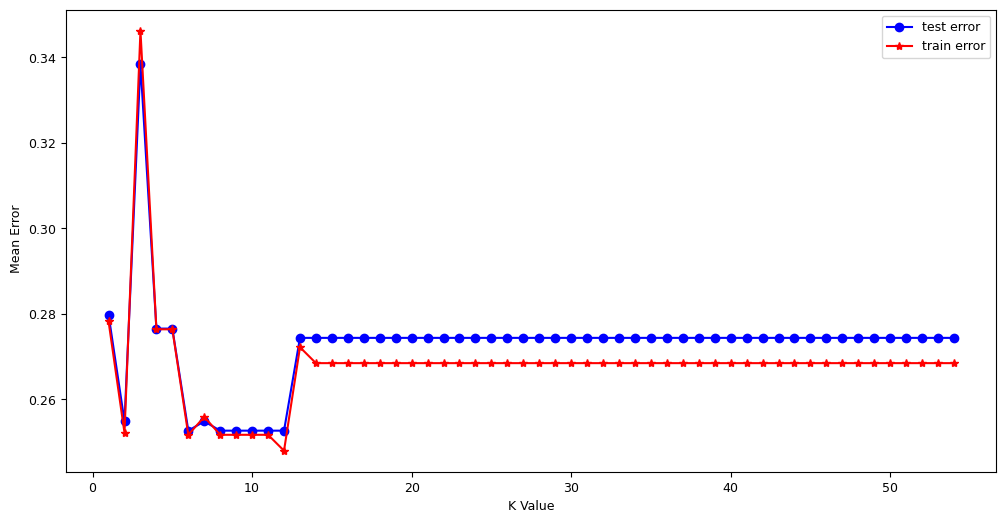

In [649]:
# Tracer l'erreur de classification en fonction des valeurs de K
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 55), error1, 'b-o', ms=6, label='test error') # Erreur de test
plt.plot(range(1, 55), error2, 'r-*', ms=6, label='train error') # Erreur d'entraînement
plt.legend()
plt.xlabel('K Value')  
plt.ylabel(' Mean Error')

In [49]:
# Calcul de l'exactitude pour différentes valeurs de K et affichage du graphique
no_neighbors = np.arange(1, 55)
train_accuracy = np.empty(len(no_neighbors))
test_accuracy = np.empty(len(no_neighbors))

for i, k in enumerate(no_neighbors):
    knn = KNeighborsClassifier(n_neighbors=k) # Définir le classifieur KNN
    knn.fit(X_train,y_train)
    train_accuracy[i] = knn.score(X_train, y_train) # Calculer l'exactitude d'entraînement
    test_accuracy[i] = knn.score(X_test, y_test) # Calculer l'exactitude de test

In [501]:
#k=12 optimal

In [658]:
from sklearn.model_selection import cross_val_score

k_range = range(1,55)

cv_scores = []

# Effectuer la validation croisée 10-fold pour chaque valeur de k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy') # Calcul des scores de validation croisée (accuracy) pour 10 folds
    cv_scores.append(scores.mean())

In [659]:
# Changer les scores pour l'erreur de classification (misclassification error)
MSE = [1 - x for x in cv_scores]

In [660]:
print('Length of list', len(cv_scores))
print('Max of list', max(cv_scores))

# Trouver la valeur de k qui minimise l'erreur de classification
optimal_k = MSE.index(min(MSE))
print("The optimal number of neighbors is %d" % optimal_k)

Length of list 54
Max of list 0.7505700325732899
The optimal number of neighbors is 39


In [661]:
import matplotlib.pyplot as plt

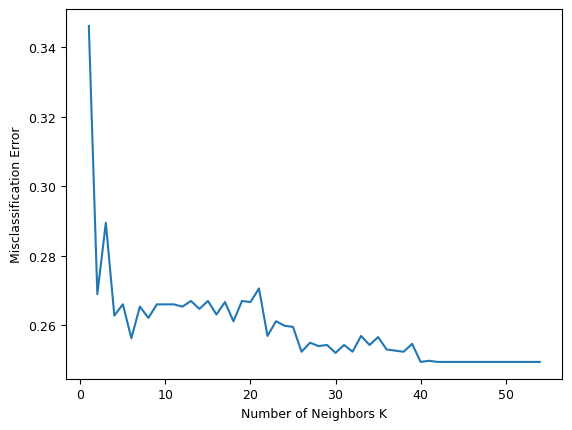

In [663]:
# Graphique de l'erreur de classification en fonction de k
plt.plot(k_range, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()
# on peut aussi regarder l'erreur de classification la + petite 

In [664]:
#k=39 optimal

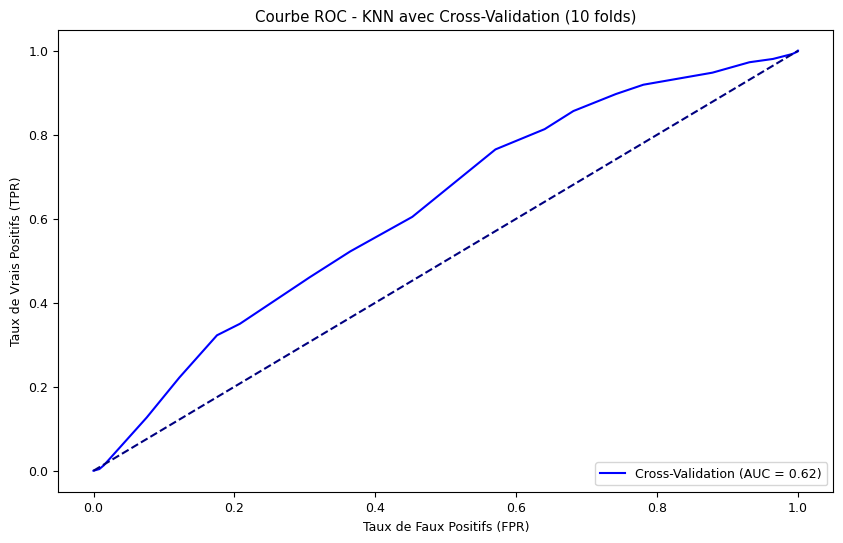

In [716]:
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
# Appliquer le KNN avec k=39
classifier = KNeighborsClassifier(n_neighbors=39)

# Prédire les probabilités en utilisant cross-validation (10-fold)
y_pred_proba_cv = cross_val_predict(classifier, X, y, cv=10, method='predict_proba')[:, 1]

# Calculer la courbe ROC et l'AUC
fpr_cv, tpr_cv, _ = roc_curve(y, y_pred_proba_cv)
auc_cv = roc_auc_score(y, y_pred_proba_cv)

# Tracer la courbe ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_cv, tpr_cv, label=f'Cross-Validation (AUC = {auc_cv:.2f})', color='blue')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.title("Courbe ROC - KNN avec Cross-Validation (10 folds)")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.legend(loc="lower right")
plt.show()

k = 1, AUC = 0.4952
k = 2, AUC = 0.5304
k = 3, AUC = 0.5394
k = 4, AUC = 0.5486
k = 5, AUC = 0.5660
k = 6, AUC = 0.5504
k = 7, AUC = 0.5491
k = 8, AUC = 0.5532
k = 9, AUC = 0.5446
k = 10, AUC = 0.5562
k = 11, AUC = 0.5676
k = 12, AUC = 0.5687
k = 13, AUC = 0.5785
k = 14, AUC = 0.5785
k = 15, AUC = 0.5662
k = 16, AUC = 0.5658
k = 17, AUC = 0.5782
k = 18, AUC = 0.5871
k = 19, AUC = 0.5856
k = 20, AUC = 0.5915
k = 21, AUC = 0.5932
k = 22, AUC = 0.5967
k = 23, AUC = 0.5994
k = 24, AUC = 0.5989
k = 25, AUC = 0.5963
k = 26, AUC = 0.6026
k = 27, AUC = 0.6047
k = 28, AUC = 0.6063
k = 29, AUC = 0.6069
k = 30, AUC = 0.6136
k = 31, AUC = 0.6193
k = 32, AUC = 0.6186
k = 33, AUC = 0.6195
k = 34, AUC = 0.6209
k = 35, AUC = 0.6203
k = 36, AUC = 0.6204
k = 37, AUC = 0.6213
k = 38, AUC = 0.6251
k = 39, AUC = 0.6315
k = 40, AUC = 0.6303
k = 41, AUC = 0.6324
k = 42, AUC = 0.6343
k = 43, AUC = 0.6323
k = 44, AUC = 0.6358
k = 45, AUC = 0.6381
k = 46, AUC = 0.6377
k = 47, AUC = 0.6389
k = 48, AUC = 0.6355
k

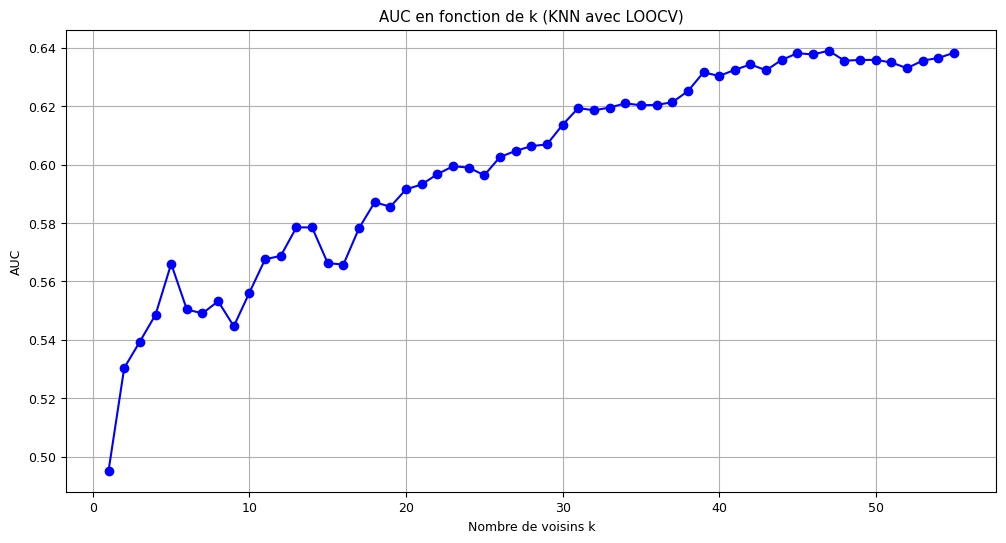

In [718]:
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Initialiser la méthode LOOCV
loo = LeaveOneOut()

# Liste des valeurs de k à tester
k_range = range(1, 56)  # Tu peux modifier cette plage selon tes besoins

# Pour stocker les AUCs
auc_scores = []

# Tester chaque valeur de k
for k in k_range:
    classifier = KNeighborsClassifier(n_neighbors=k)
    
    # Prédire les probabilités en utilisant LOOCV
    y_pred_proba_loocv = cross_val_predict(classifier, X, y, cv=loo, method='predict_proba')[:, 1]
    
    # Calculer l'AUC
    auc_score = roc_auc_score(y, y_pred_proba_loocv)
    auc_scores.append(auc_score)
    
    print(f"k = {k}, AUC = {auc_score:.4f}")

# Trouver la meilleure valeur de k (maximiser l'AUC)
optimal_k = k_range[np.argmax(auc_scores)]
best_auc = max(auc_scores)

print(f"\nMeilleur k : {optimal_k} avec une AUC de : {best_auc:.4f}")

# Tracer les résultats
plt.figure(figsize=(12, 6))
plt.plot(k_range, auc_scores, marker='o', linestyle='-', color='blue')
plt.title("AUC en fonction de k (KNN avec LOOCV)")
plt.xlabel("Nombre de voisins k")
plt.ylabel("AUC")
plt.grid(True)
plt.show()


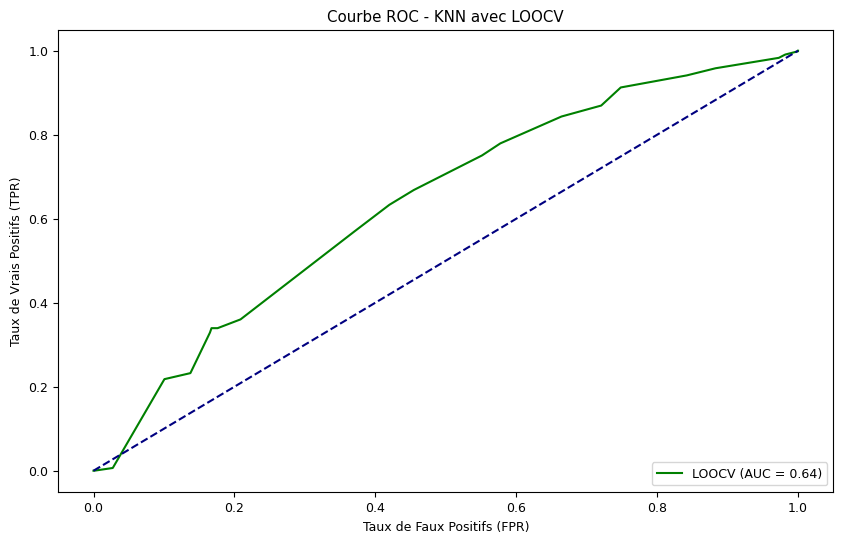

In [720]:
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Initialiser le modèle KNN avec k=47
classifier = KNeighborsClassifier(n_neighbors=47)

# Initialiser la méthode LOOCV
loo = LeaveOneOut()

# Prédire les probabilités en utilisant LOOCV
y_pred_proba_loocv = cross_val_predict(classifier, X, y, cv=loo, method='predict_proba')[:, 1]

# Calculer la courbe ROC et l'AUC
fpr_loocv, tpr_loocv, _ = roc_curve(y, y_pred_proba_loocv)
auc_loocv = roc_auc_score(y, y_pred_proba_loocv)

# Tracer la courbe ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_loocv, tpr_loocv, label=f'LOOCV (AUC = {auc_loocv:.2f})', color='green')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.title("Courbe ROC - KNN avec LOOCV")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.legend(loc="lower right")
plt.show()


#### c) Decision tree

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

df_tree2 = df.copy()

X = df.drop(['DIAGN'], axis=1)
y = df['DIAGN']

vars_significatives = ['SEXE', 'ORIENT_SEX', 'PART', 'HISTOIRE', 'AGE']
X = df_tree2[vars_significatives].copy()

# Recode
X['SEXE'] = X['SEXE'].map({0: 'Homme', 1: 'Femme'})
X['ORIENT_SEX'] = X['ORIENT_SEX'].map({0: 'Homosexuel', 1: 'Hétérosexuel'})
X['AGE'] = X['AGE'].map({0: 'Moins de 30 ans', 1: '30 ans et plus'})
X['PART'] = X['PART'].map({0: 'Peu actifs', 1: 'Très actifs'})
X['HISTOIRE'] = X['HISTOIRE'].map({0: "Pas de relation", 1: "Partenaire contaminé"})


X_n = pd.get_dummies(X, drop_first=True)

In [608]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "criterion": ["gini", "entropy"],
    "min_samples_split": [2, 5, 10, 20],
    "max_depth": range(2, 20),
    "min_samples_leaf": range(1, 10),
    "max_leaf_nodes": [None, 5, 10, 20]
}

grid_search = GridSearchCV(DecisionTreeClassifier(criterion="gini"), parameters, scoring='accuracy', n_jobs=-1, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.7519780994199599


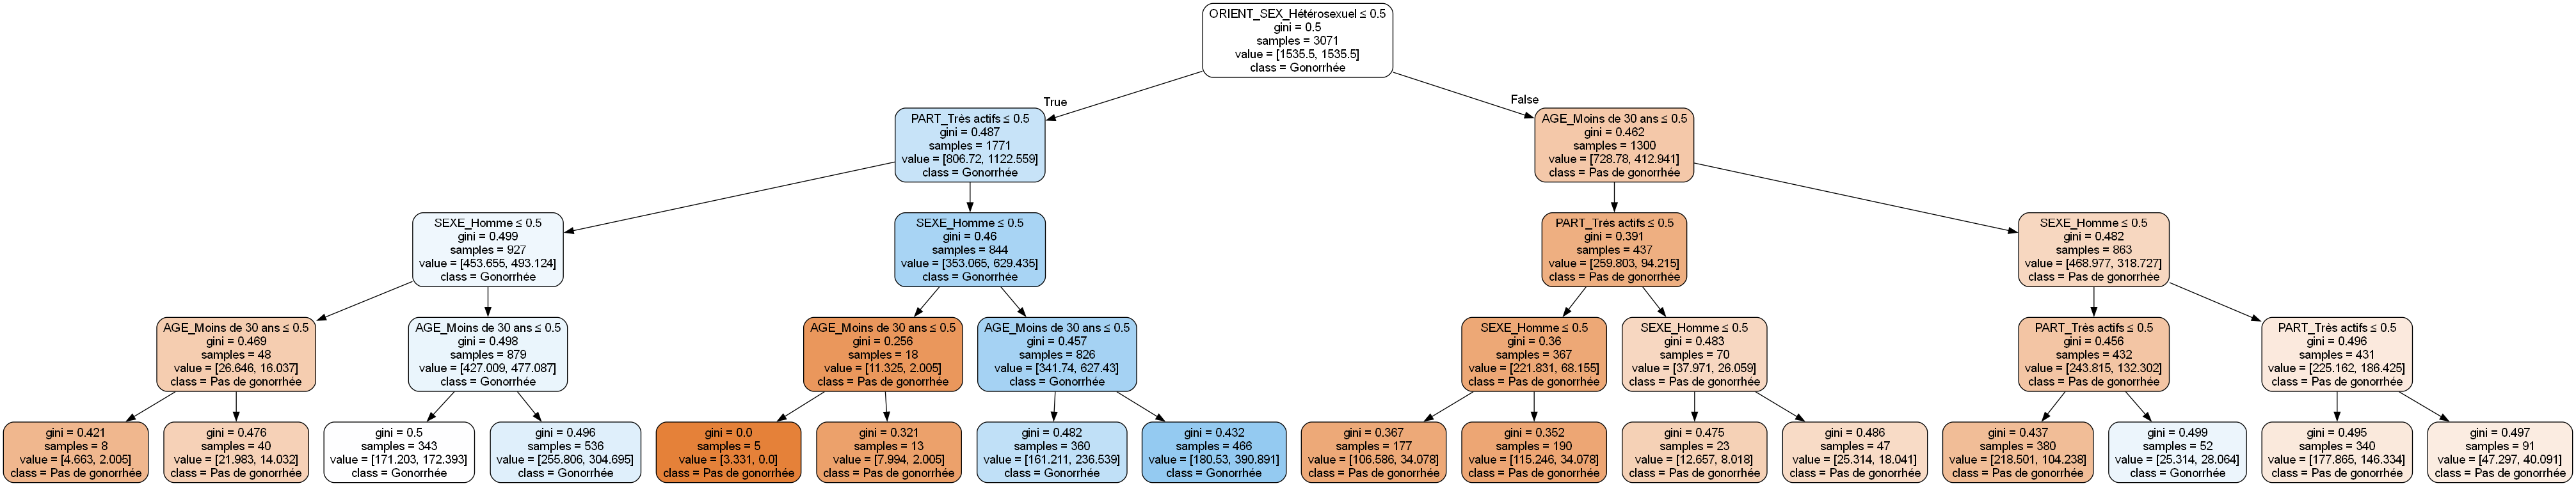

In [59]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd
import graphviz
from IPython.display import Image

# === Données préparées ===
df_tree2 = df.copy()

X = df_tree2[['SEXE', 'ORIENT_SEX', 'PART', 'AGE']].copy()
y = df_tree2['DIAGN']

# Recode (pour affichage plus lisible dans l’arbre)
X['SEXE'] = X['SEXE'].map({0: 'Homme', 1: 'Femme'})
X['ORIENT_SEX'] = X['ORIENT_SEX'].map({0: 'Homosexuel', 1: 'Hétérosexuel'})
X['AGE'] = X['AGE'].map({0: 'Moins de 30 ans', 1: '30 ans et plus'})
X['PART'] = X['PART'].map({0: 'Peu actifs', 1: 'Très actifs'})

# Encodage one-hot
X_n = pd.get_dummies(X, drop_first=True)

# === Entraînement avec les meilleurs hyperparamètres ===
clf_full = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4,
    max_leaf_nodes=None,
    min_samples_leaf=1,
    min_samples_split=2,
    class_weight='balanced',
    random_state=0
)
clf_full.fit(X_n, y)

# === Affichage de l'arbre ===
dot_data = export_graphviz(
    clf_full,
    out_file=None,
    feature_names=X_n.columns,
    class_names=['Pas de gonorrhée', 'Gonorrhée'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data, format='png')
graph.render("arbre_gonorrhee_final2", cleanup=True)
Image(filename="arbre_gonorrhee_final2.png")

In [60]:
# Supposons que tu as déjà un X_test initialisé avec les mêmes colonnes que X
X_test2 = X_test.copy()

# Recode des modalités comme dans X
X_test2['SEXE'] = X_test2['SEXE'].map({0: 'Homme', 1: 'Femme'})
X_test2['ORIENT_SEX'] = X_test2['ORIENT_SEX'].map({0: 'Homosexuel', 1: 'Hétérosexuel'})
X_test2['AGE'] = X_test2['AGE'].map({0: 'Moins de 30 ans', 1: '30 ans et plus'})
X_test2['PART'] = X_test2['PART'].map({0: 'Peu actifs', 1: 'Très actifs'})

# One-hot encoding
X_test_n = pd.get_dummies(X_test2, drop_first=True)

# S'assurer que les colonnes sont alignées avec celles de l'entraînement
# (Ajouter les colonnes manquantes si nécessaire)
X_test_n = X_test_n.reindex(columns=X_n.columns, fill_value=0)

# Prédiction maintenant sans erreur
y_pred = clf_full.predict(X_test_n)

In [61]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")

[[337 352]
 [ 53 180]]
              precision    recall  f1-score   support

           0       0.86      0.49      0.62       689
           1       0.34      0.77      0.47       233

    accuracy                           0.56       922
   macro avg       0.60      0.63      0.55       922
weighted avg       0.73      0.56      0.59       922

Accuracy : 0.5607


<br>

### III.III – Comparaison des différents modèles 

In [722]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


# Entraînement du modèle KNN
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train, y_train)

# Entraînement du modèle de Régression Logistique
X_train_const = sm.add_constant(X_train)
model_logit = sm.Logit(y_train, X_train_const).fit(disp=0)

# Prédictions KNN
y_pred_knn = knn.predict(X_test)
y_pred_knn_proba = knn.predict_proba(X_test)[:, 1]

# Prédictions Régression Logistique
X_test_const = sm.add_constant(X_test)
y_pred_logit_proba = model_logit.predict(X_test_const)
y_pred_logit = np.where(y_pred_logit_proba > 0.4, 1, 0)

# KNN Model
y_pred_knn = knn.predict(X_test)  # Your KNN model

# Logistic Regression Model
y_pred_logit = np.where(y_pred_logit_proba > 0.4, 1, 0)  # Your Logistic Regression model

# Decision Tree Model (Best from GridSearchCV)
y_pred_tree = grid_search.best_estimator_.predict(X_test)  # Your Decision Tree model #badel my a3moul clf_gini
#.fit w byerja3 .predict je fais toute ca 


In [724]:
def evaluate_model(y_test, y_pred, model_name):
    print(f"\n----- {model_name} Model Performance -----")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    try:
        auc_score = roc_auc_score(y_test, y_pred)
        print("AUC Score:", auc_score)
    except ValueError:
        print("AUC Score: Not Applicable (Check prediction format)")


In [726]:
evaluate_model(y_test, y_pred_knn, "KNN")
evaluate_model(y_test, y_pred_logit, "Logistic Regression")
evaluate_model(y_test, y_pred_tree, "Decision Tree")


----- KNN Model Performance -----
Accuracy: 0.7472885032537961
Confusion Matrix:
 [[689   0]
 [233   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86       689
           1       0.00      0.00      0.00       233

    accuracy                           0.75       922
   macro avg       0.37      0.50      0.43       922
weighted avg       0.56      0.75      0.64       922

AUC Score: 0.5

----- Logistic Regression Model Performance -----
Accuracy: 0.7472885032537961
Confusion Matrix:
 [[682   7]
 [226   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.99      0.85       689
           1       0.50      0.03      0.06       233

    accuracy                           0.75       922
   macro avg       0.63      0.51      0.46       922
weighted avg       0.69      0.75      0.65       922

AUC Score: 0.509941633392925

----- Decision Tree Model

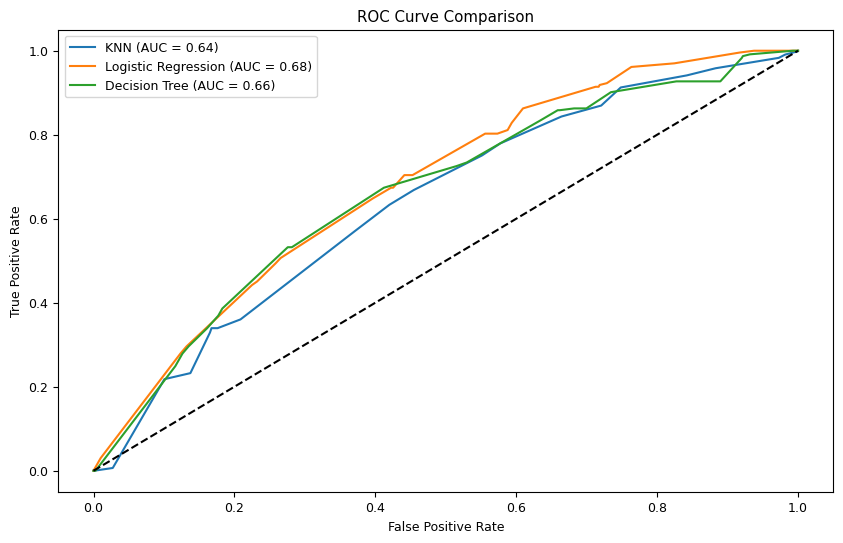

In [736]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_pred_prob_knn = cross_val_predict(knn, X, y, cv=loo, method='predict_proba')[:, 1]
y_pred_prob_logit = model_logit.predict(X_test_const)
y_pred_prob_tree = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# COURBE ROC
plt.figure(figsize=(10, 6))

# KNN
fpr_knn, tpr_knn, _ = roc_curve(y, y_pred_prob_knn)
auc_knn = roc_auc_score(y, y_pred_prob_knn)
plt.plot(fpr_knn, tpr_knn, label='KNN (AUC = {:.2f})'.format(roc_auc_score(y, y_pred_prob_knn)))

# Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_prob_logit)
plt.plot(fpr_logreg, tpr_logreg, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_prob_logit)))

# Decision Tree
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_prob_tree)
plt.plot(fpr_tree, tpr_tree, label='Decision Tree (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_prob_tree)))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.show()

<br>

----

## **IV - CARACTERISATION DES GROUPES A RISQUE**

In [750]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import numpy as np
import itertools

# Définir les variables binaires
selected_columns = ['AGE', 'SEXE', 'ORIENT_SEX', 'PART']
X = df[selected_columns]
y = df['DIAGN']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_const = sm.add_constant(X_train)

# régression logistique
lr = sm.Logit(y_train, X_train_const)
model = lr.fit()
print(model.summary())

intercept = model.params['const']
coefficients = {col: model.params[col] for col in selected_columns}

# Générer toutes les combinaisons possibles des variables binaires (0 ou 1)
combinations = list(itertools.product([0, 1], repeat=len(selected_columns)))

# log-odds, odds ratios et probabilités pour chaque combinaison
results = []
for combination in combinations:
    log_odds = intercept
    description = {}
    for i, var in enumerate(selected_columns):
        log_odds += coefficients[var] * combination[i]
        description[var] = combination[i]
    odds = np.exp(log_odds)
    probability = odds / (1 + odds)
    results.append({
        **description,
        'Log-Odds': log_odds,
        'Odds Ratio': odds,
        'Probability': probability
    })

results_df = pd.DataFrame(results)
print("\nRésultats pour chaque combinaison :")
print(results_df)

Optimization terminated successfully.
         Current function value: 0.537345
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  DIAGN   No. Observations:                 2149
Model:                          Logit   Df Residuals:                     2144
Method:                           MLE   Df Model:                            4
Date:                Tue, 08 Apr 2025   Pseudo R-squ.:                 0.04072
Time:                        00:37:44   Log-Likelihood:                -1154.8
converged:                       True   LL-Null:                       -1203.8
Covariance Type:            nonrobust   LLR p-value:                 2.590e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0220      0.214      0.103      0.918      -0.397       0.441
AGE           -0.3417      0.